# Trabajo Final - Hormigones

El problema de negocio que se está evaluando corresponde a Cementos Perú (CP), una importante empresa de materiales de construcción. CP cuenta con información histórica del proceso productivo del concreto y desea utilizar machine learning para encontrar mejoras en el diseño de este material y predecir, para los despachos producidos en la región metropolitana, y para los productos normales, la resistencia promedio en el día 28 del concreto. 

In [ ]:
# Paquetes a descargar
# pip install graphviz
# pip install scikit-learn

In [157]:
# Cargar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from tqdm import tqdm
from numpy import linalg as LA
from datetime import datetime
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
from tabulate import tabulate
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Importamos las tablas

ruta = '/Users/valerie/Desktop/Data/CAA_AP_TABLA' # cambiar por la ruta que tengas
tablas = {}

for i in range(1, 8):
    archivo = ruta + str(i) + '.csv'
    dfi = 'df' + str(i)
    globals()[dfi] = pd.read_csv(archivo, low_memory=False)
    
    # Convertir las columnas numéricas a int o float correspondientemente
    globals()[dfi] = globals()[dfi].convert_dtypes()

## 1. Preprocesamiento: Unión de las tablas y creación de variables relevantes

### Tabla 1

In [4]:
# Tamaño del dataset
df1.shape

(994740, 12)

In [5]:
# Tipo de datos del dataset 1
df1.dtypes

CODIGO_GUIA_DESPACHO     string
FECHA_GUIA_DESPACHO       Int64
CODIGO_PRODUCTO           Int64
DESCRIPCION_PRODUCTO     string
PRODUCTO_VAP             string
CODIGO_SUCURSAL           Int64
ANILLO                    Int64
HORA_IMPRESO_GUIA        string
HORA_CARGA               string
CANTIDAD_A_FACTURAR     Float64
TAMANO                   string
FILA_DUPLICADO_GUIA       Int64
dtype: object

In [6]:
# Vemos que la variable 'CODIGO_GUIA_DESPACHO' se guardó como string
# Entonces usamos la siguiente expresión para encontrar caracteres no numéricos
patron_no_numerico = re.compile('[^\d]+')

# Imprime el resultado
print(df1[df1['CODIGO_GUIA_DESPACHO'].str.contains(patron_no_numerico)])

       CODIGO_GUIA_DESPACHO  FECHA_GUIA_DESPACHO  CODIGO_PRODUCTO  \
61857              7420077|             20170207             1780   
717018             .7341323             20160804            27821   
717019             |7752845             20170821              881   
779050             7078/989             20160225              706   

             DESCRIPCION_PRODUCTO PRODUCTO_VAP  CODIGO_SUCURSAL  ANILLO  \
61857                 HN050804006          STD              332     100   
717018  SH3009010F MS5 METRO P8 N          VAP              131     300   
717019                HB250902012          STD              420     300   
779050                HN200904006          STD              332     100   

       HORA_IMPRESO_GUIA HORA_CARGA  CANTIDAD_A_FACTURAR TAMANO  \
61857               <NA>       <NA>                  3.5      L   
717018             06:22      06:22                  6.0     XL   
717019             21:07      21:09                  7.0     MM   
779050    

In [7]:
# Limpiamos los valores no numéricos eliminando los typos
df1['CODIGO_GUIA_DESPACHO'] = df1['CODIGO_GUIA_DESPACHO'].str.replace('|', '')
df1['CODIGO_GUIA_DESPACHO'] = df1['CODIGO_GUIA_DESPACHO'].str.replace('.', '')
df1['CODIGO_GUIA_DESPACHO'] = df1['CODIGO_GUIA_DESPACHO'].str.replace('/', '')
df1['CODIGO_GUIA_DESPACHO'] = df1['CODIGO_GUIA_DESPACHO'].str.replace(' ', '')

In [8]:
# Ahora sí, transformamos la primera columna en int
df1['CODIGO_GUIA_DESPACHO'] = df1['CODIGO_GUIA_DESPACHO'].astype('Int64')

In [9]:
# Primeras filas del dataset
df1.head()

,CODIGO_GUIA_DESPACHO,FECHA_GUIA_DESPACHO,CODIGO_PRODUCTO,DESCRIPCION_PRODUCTO,PRODUCTO_VAP,CODIGO_SUCURSAL,ANILLO,HORA_IMPRESO_GUIA,HORA_CARGA,CANTIDAD_A_FACTURAR,TAMANO,FILA_DUPLICADO_GUIA
0,7345803,20160906,811,HN250902008,STD,141,200,09:37,09:45,7.0,MM,1
1,7345806,20160906,10818,HN3009020F+04 SSP,VAP,141,200,10:08,10:18,7.5,XL,1
2,7345807,20160906,28957,HB300902010 DT,VAP,141,100,10:13,10:16,7.0,XL,1
3,7345809,20160906,874,HB300902010,STD,141,200,10:21,10:39,7.5,XL,1
4,7345810,20160906,811,HN250902008,STD,141,200,10:29,10:45,7.0,MM,1


In [10]:
# Vemos qué es 'FILA_DUPLICADO_GUIA' que no aparece en el diccionario
print(df1['FILA_DUPLICADO_GUIA'].value_counts())

1    994610
2       130
Name: FILA_DUPLICADO_GUIA, dtype: Int64


In [11]:
# Eliminamos esa variable
df1.drop('FILA_DUPLICADO_GUIA', axis=1, inplace=True)

In [12]:
# Nos quedamos solo los despachos de la región metropolitana
sucursal_metro = [101, 111, 121, 122, 123, 131, 132, 133, 151]
df1 = df1[df1['CODIGO_SUCURSAL'].isin(sucursal_metro)]

In [13]:
# Consideramos los productos normales, es decir:

# Aquellos de tipo 'STD'
df1 = df1.loc[df1['PRODUCTO_VAP'] == 'STD']

# Los que tienen únicamente descripciones de 11 caracteres
df1 = df1[df1['DESCRIPCION_PRODUCTO'].str.len() == 11]

# Y los que empiezan con 'GB', 'GR', 'HN' o 'HB'
df1 = df1[df1['DESCRIPCION_PRODUCTO'].str.startswith(('GB', 'GR', 'HN', 'HB'))]

In [14]:
# Verificamos si hay códigos repetidos en la data
columna = 'CODIGO_GUIA_DESPACHO'

# Obtener los valores duplicados y contar su frecuencia
valores_duplicados = df1[columna][df1[columna].duplicated(keep=False)]
frecuencia_duplicados = valores_duplicados.value_counts()

print("Valores duplicados:")
print(valores_duplicados)
print("\nFrecuencia de los valores duplicados:")
print(frecuencia_duplicados)

Valores duplicados:
144620    7523017
144621    7523017
146106    7524633
146107    7524633
Name: CODIGO_GUIA_DESPACHO, dtype: Int64

Frecuencia de los valores duplicados:
7523017    2
7524633    2
Name: CODIGO_GUIA_DESPACHO, dtype: Int64


In [15]:
# Eliminamos los duplicados, manteniendo la primera aparición
df1 = df1.drop_duplicates(subset=columna, keep='first')

In [16]:
# Se verifica si hay nulos
df1.isnull().sum()

CODIGO_GUIA_DESPACHO        0
FECHA_GUIA_DESPACHO         0
CODIGO_PRODUCTO             0
DESCRIPCION_PRODUCTO        0
PRODUCTO_VAP                0
CODIGO_SUCURSAL             0
ANILLO                     11
HORA_IMPRESO_GUIA         210
HORA_CARGA              35743
CANTIDAD_A_FACTURAR         0
TAMANO                      1
dtype: int64

In [17]:
# Decidimos quedarnos con la variable 'HORA_CARGA' que indica cuándo efectivamente se empezó a hacer el concreto
# Para no volarnos tantos nulos, los rellenamos con la 'HORA_IMPRESO_GUIA' que tiene algunos minutos de diferencia
df1['HORA_CARGA'] = np.where(df1['HORA_CARGA'].isnull() & df1['HORA_IMPRESO_GUIA'].notnull(),
                            df1['HORA_IMPRESO_GUIA'], df1['HORA_CARGA'])

# Luego eliminamos la variable 'HORA_IMPRESO_GUIA'
df1.drop('HORA_IMPRESO_GUIA', axis=1, inplace=True)

In [18]:
# Eliminamos los nulos
df1.dropna(axis=0, inplace=True)

# Luego, reseteamos los índices del DF
df1.reset_index(inplace=True, drop=True)

In [19]:
# Se obtienen las siguientes variables de la columna "DESCRIPCION_PRODUCTO":
df1["TIPO_CONCRETO"] = df1["DESCRIPCION_PRODUCTO"].str[:2]
df1["RESISTENCIA_ESPECIFICADA"] = df1["DESCRIPCION_PRODUCTO"].str[2:5]
df1["NIVEL_CONFIANZA"] = df1["DESCRIPCION_PRODUCTO"].str[5:7]
df1["TAMAÑO_ARIDO"] = df1["DESCRIPCION_PRODUCTO"].str[7:9]
df1["CONO_ABRAMS"] = df1["DESCRIPCION_PRODUCTO"].str[9:11]

# Se cambia el formato a Int64 de las variables numéricas
df1["RESISTENCIA_ESPECIFICADA"] = df1["RESISTENCIA_ESPECIFICADA"].astype("Int64")
df1["NIVEL_CONFIANZA"] = df1["NIVEL_CONFIANZA"].astype("Int64")
df1["TAMAÑO_ARIDO"] = df1["TAMAÑO_ARIDO"].astype("Int64")
df1["CONO_ABRAMS"] = df1["CONO_ABRAMS"].astype("Int64")

In [20]:
# Convertimos la columna 'FECHA_GUIA_DESPACHO' a formato fecha
df1['FECHA_GUIA_DESPACHO'] = pd.to_datetime(df1['FECHA_GUIA_DESPACHO'], format='%Y%m%d')

# Y la columna 'HORA_CARGA' a formato hora
df1['HORA_CARGA'] = pd.to_datetime(df1['HORA_CARGA'], format='%H:%M')


In [21]:
df1.dtypes

CODIGO_GUIA_DESPACHO                 Int64
FECHA_GUIA_DESPACHO         datetime64[ns]
CODIGO_PRODUCTO                      Int64
DESCRIPCION_PRODUCTO                string
PRODUCTO_VAP                        string
CODIGO_SUCURSAL                      Int64
ANILLO                               Int64
HORA_CARGA                  datetime64[ns]
CANTIDAD_A_FACTURAR                Float64
TAMANO                              string
TIPO_CONCRETO                       string
RESISTENCIA_ESPECIFICADA             Int64
NIVEL_CONFIANZA                      Int64
TAMAÑO_ARIDO                         Int64
CONO_ABRAMS                          Int64
dtype: object

In [22]:
df1.shape

(183272, 15)

In [23]:
df1.head()

,CODIGO_GUIA_DESPACHO,FECHA_GUIA_DESPACHO,CODIGO_PRODUCTO,DESCRIPCION_PRODUCTO,PRODUCTO_VAP,CODIGO_SUCURSAL,ANILLO,HORA_CARGA,CANTIDAD_A_FACTURAR,TAMANO,TIPO_CONCRETO,RESISTENCIA_ESPECIFICADA,NIVEL_CONFIANZA,TAMAÑO_ARIDO,CONO_ABRAMS
0,7358704,2016-08-20,10023,HB350904014,STD,132,300,1900-01-01 08:20:00,7.5,XL,HB,350,90,40,14
1,7358705,2016-08-20,882,HB300902012,STD,132,200,1900-01-01 08:24:00,7.0,XL,HB,300,90,20,12
2,7358709,2016-08-20,706,HN200904006,STD,132,300,1900-01-01 08:52:00,7.5,SPOT,HN,200,90,40,6
3,7358711,2016-08-20,850,HB300904010,STD,132,200,1900-01-01 09:11:00,7.0,XL,HB,300,90,40,10
4,7358712,2016-08-20,10023,HB350904014,STD,132,300,1900-01-01 09:12:00,7.5,XL,HB,350,90,40,14


### Tabla 2

In [24]:
# Tamaño del dataset
df2.shape

(63387, 7)

In [25]:
df2.dtypes

NUMERO_GUIA              Int64
LABORATORIO              Int64
DESCRIPCION_PRODUCTO    string
TIPO_ENSAYO             string
R28_1                    Int64
R28_2                    Int64
FLAG_MUESTRA_NULA        Int64
dtype: object

In [26]:
# Primeras filas del dataset
df2.head()

,NUMERO_GUIA,LABORATORIO,DESCRIPCION_PRODUCTO,TIPO_ENSAYO,R28_1,R28_2,FLAG_MUESTRA_NULA
0,1510036,2,HB250902010,C,272,274,0
1,1510085,2,HB350904010 PNT,C,428,420,0
2,1510086,2,HB300902010 02,C,405,404,0
3,1510135,2,HN250902010,C,0,0,0
4,1510148,2,HN250902010-03,C,531,0,0


In [27]:
# Consideramos las muestras de tipo de ensayo de comprensión ('C')
df2 = df2.loc[df2['TIPO_ENSAYO'] == 'C']

In [28]:
# Se verifica si hay nulos
df2.isnull().sum()

NUMERO_GUIA             0
LABORATORIO             0
DESCRIPCION_PRODUCTO    0
TIPO_ENSAYO             0
R28_1                   0
R28_2                   0
FLAG_MUESTRA_NULA       0
dtype: int64

In [29]:
# Vemos que todas las muestras tomadas son no nulas (FLAG_MUESTRA_NULA = 0)
df2.describe()

,NUMERO_GUIA,LABORATORIO,R28_1,R28_2,FLAG_MUESTRA_NULA
count,5.923800e+04,59238.000000,59238.000000,59238.000000,59238.0
mean,7.581774e+06,17.079915,383.252304,354.234917,0.0
std,6.399488e+05,27.612977,4108.829263,4109.667766,0.0
min,7.810000e+02,1.000000,0.000000,0.000000,0.0
25%,7.301671e+06,2.000000,309.000000,296.000000,0.0
50%,7.589304e+06,2.000000,356.000000,345.000000,0.0
75%,7.865552e+06,5.000000,422.000000,404.000000,0.0
max,7.554416e+07,88.000000,999999.000000,999999.000000,0.0


In [30]:
# Calculamos la resistencia promedio de las dos muestras
df2['R28_PROMEDIO'] = df2[['R28_1', 'R28_2']].mean(axis=1)
df2.loc[df2['R28_1'] == 0, 'R28_PROMEDIO'] = df2['R28_2']
df2.loc[df2['R28_2'] == 0, 'R28_PROMEDIO'] = df2['R28_1']

In [31]:
# Podemos dropear las columnas 'TIPO_ENSAYO' y 'FLAG_MUESTRA_NULA' que no tienen variación
df2 = df2.drop(['TIPO_ENSAYO', 'FLAG_MUESTRA_NULA'], axis=1)
# Y las columnas de las muestras 1 y 2 que ya usamos para calcular el promedio
df2 = df2.drop(['R28_1', 'R28_2'], axis=1)

In [32]:
# Nos quedamos solo con aquellas observaciones que no tienen 0 en ambas muestras de resistencia
df2 = df2[df2['R28_PROMEDIO'] != 0]

In [33]:
# Luego, reseteamos los índices del DF
df2.reset_index(inplace=True, drop=True)

In [34]:
# Identificar los valores duplicados en la columna CODIGO_GUIA_DESPACHO
valores_duplicados = df2[df2.duplicated(subset='NUMERO_GUIA', keep=False)]['NUMERO_GUIA']

# Obtener los valores no únicos
valores_no_unicos = valores_duplicados.unique()

# Mostrar los valores no únicos
print("Valores no únicos en la columna NUMERO_GUIA:")
for valor in valores_no_unicos:
    print(valor)

Valores no únicos en la columna NUMERO_GUIA:
6976562
7049183
7029301
7069701
7057059
7098178
7080949
7080951
7081043
7074737
7074937
7081795
7102322
7103460
7105425
7109484
7143191
7162204
7129218
7163540
7129563
7129679
7138283
7174970
7200026
7185156
7224820
7241101
7259490
7274956
7260461
7260489
7281724
7284463
7293113
7293208
7287508
7299674
7326565
7351628
7344654
7365007
7378249
7397041
7394122
7395483
7387828
7407430
7422774
7445973
7457707
7457708
7457709
7477063
7483568
7518074
7530903
7530907
7530909
7530935
7530939
7530955
7531116
7531227
7526004
7530140
7530848
7530849
7530870
7530871
7530889
7530892
7530893
7562189
7565007
7575845
7598318
7600575
7601674
7601681
7631003
7621566
7626682
7652899
7662702
7653104
7653108
7664157
7672507
7672580
7673076
7687826
7694181
7711871
7712091
7712098
7715896
7703750
7698616
7698618
7748768
7737864
7746427
7733077
7751429
7756393
7756757
7756836
7756955
7784119
7793293
7796726
7802645
7805813
7791266
7856396
7859416
7878988
7879231
784

In [35]:
# Vemos que en algunos casos se sacaron dos muestras para el mismo despacho en diferentes lab
print(df2.loc[df2['NUMERO_GUIA'] == 7163540])

      NUMERO_GUIA  LABORATORIO DESCRIPCION_PRODUCTO  R28_PROMEDIO
6222      7163540            2    HB250902010 AC045         438.0
6223      7163540           88    HB250902010 AC045         338.0


In [36]:
# O en un mimso lab
print(df2.loc[df2['NUMERO_GUIA'] == 7129218])

      NUMERO_GUIA  LABORATORIO DESCRIPCION_PRODUCTO  R28_PROMEDIO
6116      7129218           88          HB350902012         357.5
6117      7129218           88          HB350902012         420.0


In [37]:
# Optamos por quedarnos con el promedio de las muestras que se realizan para tener un mismo pedido por fila
# En el caso en que la muestra sea de diferentes laboratorios, nos quedamos con el laboratorio que sacó una menor resistencia (para ser conservadores con los resultados)

# Calcular el valor promedio de R28_PROMEDIO y seleccionar el valor mínimo de LABORATORIO para cada combinación única de CODIGO_GUIA_DESPACHO y DESCRIPCION_PRODUCTO
df2= df2.groupby(['NUMERO_GUIA', 'DESCRIPCION_PRODUCTO']).agg({'R28_PROMEDIO': 'mean', 'LABORATORIO': 'min'}).reset_index()

# Renombrar las columnas
df2 = df2.rename(columns={'R28_PROMEDIO': 'R28_PROMEDIO_PROMEDIO', 'LABORATORIO': 'LABORATORIO_NUEVO'})


In [38]:
# Cambiamos el nombre de la columna para que coincida con la Tabla 1
df2 = df2.rename(columns={'NUMERO_GUIA': 'CODIGO_GUIA_DESPACHO'})


In [39]:
df2 = df2.rename(columns={'R28_PROMEDIO_PROMEDIO': 'R28_PROMEDIO'})
df2 = df2.rename(columns={'LABORATORIO_NUEVO': 'LABORATORIO'})

In [40]:
df2.head()

,CODIGO_GUIA_DESPACHO,DESCRIPCION_PRODUCTO,R28_PROMEDIO,LABORATORIO
0,7594,HN200902006 RK,339.5,3
1,7949,HN250902008,346.0,57
2,8116,HB300902014 PNT,392.0,57
3,758062,HB300902010,840.0,55
4,868438,HN350904006,394.0,1


In [41]:
df2.shape

(57684, 4)

### Tabla 3

In [42]:
# Tamaño del dataset
df3.shape

(6319326, 5)

In [43]:
# Vemos cómo se guardaron los tipos de datos
df3.dtypes

CODIGO_GUIA_DESPACHO          string
INSUMO_CANTIDAD_REQUERIDA    Float64
INSUMO_CANTIDAD_CONSUMIDA    Float64
INSUMO                        string
TIPO_INSUMO                   string
dtype: object

In [44]:
# Como 'CODIGO_GUIA_DESPACHO' se guardó como string, vemos cuáles son los valores que impiden que se guarde como int
print(df3['CODIGO_GUIA_DESPACHO'][~df3['CODIGO_GUIA_DESPACHO'].str.isnumeric()].unique())

<StringArray>
[       '#',       'CC', '7078/989', '.7341321', '.7341323', '7420077|',
        '|', '7636349O', '|7752845', '7703430I',     'DGJD',        'O',
       'Q1']
Length: 13, dtype: string


In [45]:
# Limpiamos aquellos números que tienen typos
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].str.replace('.', '')
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].str.replace('/', '')
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].str.replace('|', '')
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].str.replace('O', '')
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].str.replace('I', '')

In [46]:
# Eliminamos el resto de valores que no son numéricos
df3 = df3[~df3['CODIGO_GUIA_DESPACHO'].isin(df3['CODIGO_GUIA_DESPACHO'][~df3['CODIGO_GUIA_DESPACHO'].str.isnumeric()].unique())]

In [47]:
# Ahora sí, transformamos la primera columna en int
df3['CODIGO_GUIA_DESPACHO'] = df3['CODIGO_GUIA_DESPACHO'].astype('Int64')

In [48]:
# Se verifica si hay nulos
df3.isnull().sum()

CODIGO_GUIA_DESPACHO             7
INSUMO_CANTIDAD_REQUERIDA    56791
INSUMO_CANTIDAD_CONSUMIDA    56791
INSUMO                       56791
TIPO_INSUMO                      0
dtype: int64

In [49]:
# Consideramos que si 'INSUMO_CANTIDAD_REQUERIDA' y 'INSUMO_CANTIDAD_CONSUMIDA' están vacíos, se usó 0 de ese insumo
# Por eso, completamos los vacíos con 0
df3['INSUMO_CANTIDAD_REQUERIDA'].fillna(0, inplace=True)
df3['INSUMO_CANTIDAD_CONSUMIDA'].fillna(0, inplace=True)

In [50]:
# Eliminamos los nulos que quedaban en 'CODIGO_GUIA_DESPACHO'
df3 = df3[df3['CODIGO_GUIA_DESPACHO'] != '']

# Luego, reseteamos los índices del DF
df3.reset_index(inplace=True, drop=True)

In [51]:
# Primeras filas del dataset
df3.head()

,CODIGO_GUIA_DESPACHO,INSUMO_CANTIDAD_REQUERIDA,INSUMO_CANTIDAD_CONSUMIDA,INSUMO,TIPO_INSUMO
0,7037902,0.0,0.0,<NA>,OTRO
1,7037903,0.0,0.0,<NA>,OTRO
2,7037904,0.0,0.0,<NA>,OTRO
3,7037905,0.0,0.0,<NA>,OTRO
4,7037906,0.0,0.0,<NA>,OTRO


In [52]:
# Añadimos variable 'CANTIDAD_A_FACTURAR' de df1 para calcular la dosificación consumida según tipo de insumo
df3 = pd.merge(df3, df1[['CODIGO_GUIA_DESPACHO', 'CANTIDAD_A_FACTURAR']], on = "CODIGO_GUIA_DESPACHO" )
df3["INSUMO_CANTIDAD_CONSUMIDA"] = df3["INSUMO_CANTIDAD_CONSUMIDA"]/df3["CANTIDAD_A_FACTURAR"]
df3 = df3.rename(columns={'INSUMO_CANTIDAD_CONSUMIDA': 'INSUMO_CANTIDAD_CONSUMIDA_M3'})

In [53]:
df3.shape

(1092219, 6)

### Tabla 4

In [54]:
# Tamaño del dataset
df4.shape

(3090666, 4)

In [55]:
# Se renombran las columnas para que coincidan con la Tabla 3
df4 = df4.rename(columns={'NUMERO_GUIA': 'CODIGO_GUIA_DESPACHO', 'MATERIA_PRIMA': 'INSUMO', 'TIPO_MATERIA_PRIMA': 'TIPO_INSUMO'})
# Primeras filas del dataset
df4.head()

,CODIGO_GUIA_DESPACHO,FACTOR_HUMEDAD,INSUMO,TIPO_INSUMO
0,6942085,2.1,GL_VICENTE,GRAVILLA
1,6945113,8.0,AR_DOWLING,ARENA
2,6945113,2.8,GL_DOWLING,GRAVILLA
3,6957643,9.9,AR_MEL-PSB,ARENA
4,6957643,1.5,GL_MEL-PSB,GRAVILLA


In [56]:
# Verificamos si hay nulos
df4.isnull().sum()

CODIGO_GUIA_DESPACHO    0
FACTOR_HUMEDAD          0
INSUMO                  0
TIPO_INSUMO             3
dtype: int64

In [57]:
# Eliminamos los nulos
df4.dropna(axis=0, inplace=True)

# Luego, reseteamos los índices del DF
df4.reset_index(inplace=True, drop=True)

### Tabla 5

In [58]:
# Tamaño del dataset
df5.shape

(26388, 2)

In [59]:
# Primeras filas del dataset
df5.head()

,Fecha,Temp
0,31/12/2015 19:00,19
1,31/12/2015 21:00,18
2,31/12/2015 22:00,16
3,01/01/2016 01:00,15
4,01/01/2016 02:00,14


In [60]:
# Se verifica que no haya nulos
df5.isnull().sum()

Fecha    0
Temp     0
dtype: int64

In [61]:
# Separar la fecha y la hora en columnas separadas
df5[['Fecha', 'Hora']] = df5['Fecha'].str.split(' ', 1, expand=True)

# Convertir la columna "Fecha" y "Hora" al formato de fecha
df5['Fecha'] = pd.to_datetime(df5['Fecha'], dayfirst=True)
df5['Hora'] = pd.to_datetime(df5['Hora'], format='%H:%M')

In [62]:
df5 = df5.rename(columns={'Fecha': 'FECHA_GUIA_DESPACHO', 'Hora': 'HORA_CARGA'})

In [63]:
df5.head()

,FECHA_GUIA_DESPACHO,Temp,HORA_CARGA
0,2015-12-31,19,1900-01-01 19:00:00
1,2015-12-31,18,1900-01-01 21:00:00
2,2015-12-31,16,1900-01-01 22:00:00
3,2016-01-01,15,1900-01-01 01:00:00
4,2016-01-01,14,1900-01-01 02:00:00


### Tabla 6

In [64]:
# Tamaño del dataset
df6.shape

(13703, 4)

In [65]:
# Primeras filas del dataset
df6.head()

,CODIGO_MATERIAL,FECHA_MUESTRA,MODULO_FINURAS,MODULO_FINURAS_TEORICO
0,A10SG,2016-01-04,3.56,3.38
1,AR_GARZAS,2016-01-04,3.4338,3.02
2,AR_MEL-PSB,2016-01-04,3.41,3.1
3,AR_MELST,2016-01-04,3.57,3.3
4,G20S,2016-01-04,6.97,6.97


In [66]:
# Convertimos la columna 'FECHA_MUESTRA' a formato fecha
df6['FECHA_MUESTRA'] = pd.to_datetime(df6['FECHA_MUESTRA'])

In [67]:
# Se renombran las columnas para que coincidan con la Tabla 3
df6 = df6.rename(columns={'CODIGO_MATERIAL': 'INSUMO', 'FECHA_MUESTRA': 'FECHA_GUIA_DESPACHO'})

In [68]:
df6.dtypes

INSUMO                            string
FECHA_GUIA_DESPACHO       datetime64[ns]
MODULO_FINURAS                   Float64
MODULO_FINURAS_TEORICO           Float64
dtype: object

### Tabla 346: la unión de las tablas 3, 4 y 6

In [69]:
# Añadimos variable 'FECHA_GUIA_DESPACHO' de df1 al df3 para poder unirlo con el df6
df3 = pd.merge(df3, df1[['CODIGO_GUIA_DESPACHO', 'FECHA_GUIA_DESPACHO']], on = "CODIGO_GUIA_DESPACHO" )

In [70]:
df3.head()

,CODIGO_GUIA_DESPACHO,INSUMO_CANTIDAD_REQUERIDA,INSUMO_CANTIDAD_CONSUMIDA_M3,INSUMO,TIPO_INSUMO,CANTIDAD_A_FACTURAR,FECHA_GUIA_DESPACHO
0,7050425,13950.0,1860.0,AD_MX-1390,ADITIVO,7.5,2016-01-04
1,7050425,1246.0,164.0,AR_MEL-JC,ARENA,7.5,2016-01-04
2,7050425,7299.0,973.333333,AR_MEL-PSB,ARENA,7.5,2016-01-04
3,7050425,2678.0,353.866667,CE_MEPX,CEMENTO,7.5,2016-01-04
4,7050425,5783.0,768.0,GL_MEL-PSB,GRAVILLA,7.5,2016-01-04


In [71]:
df6.head()

,INSUMO,FECHA_GUIA_DESPACHO,MODULO_FINURAS,MODULO_FINURAS_TEORICO
0,A10SG,2016-01-04,3.56,3.38
1,AR_GARZAS,2016-01-04,3.4338,3.02
2,AR_MEL-PSB,2016-01-04,3.41,3.1
3,AR_MELST,2016-01-04,3.57,3.3
4,G20S,2016-01-04,6.97,6.97


In [72]:
# Unir los dataframes df3 y df6 utilizando merge
df36 = pd.merge(df3, df6[['INSUMO', 'FECHA_GUIA_DESPACHO', 'MODULO_FINURAS', 'MODULO_FINURAS_TEORICO']], 
                     on=['INSUMO', 'FECHA_GUIA_DESPACHO'], how='left')

In [73]:
df36.head()

,CODIGO_GUIA_DESPACHO,INSUMO_CANTIDAD_REQUERIDA,INSUMO_CANTIDAD_CONSUMIDA_M3,INSUMO,TIPO_INSUMO,CANTIDAD_A_FACTURAR,FECHA_GUIA_DESPACHO,MODULO_FINURAS,MODULO_FINURAS_TEORICO
0,7050425,13950.0,1860.0,AD_MX-1390,ADITIVO,7.5,2016-01-04,<NA>,<NA>
1,7050425,1246.0,164.0,AR_MEL-JC,ARENA,7.5,2016-01-04,<NA>,<NA>
2,7050425,7299.0,973.333333,AR_MEL-PSB,ARENA,7.5,2016-01-04,3.41,3.1
3,7050425,2678.0,353.866667,CE_MEPX,CEMENTO,7.5,2016-01-04,<NA>,<NA>
4,7050425,5783.0,768.0,GL_MEL-PSB,GRAVILLA,7.5,2016-01-04,<NA>,<NA>


In [74]:
df4.head()

,CODIGO_GUIA_DESPACHO,FACTOR_HUMEDAD,INSUMO,TIPO_INSUMO
0,6942085,2.1,GL_VICENTE,GRAVILLA
1,6945113,8.0,AR_DOWLING,ARENA
2,6945113,2.8,GL_DOWLING,GRAVILLA
3,6957643,9.9,AR_MEL-PSB,ARENA
4,6957643,1.5,GL_MEL-PSB,GRAVILLA


In [75]:
# Unir los dataframes df36 y df4 utilizando 'CODIGO_GUIA_DESPACHO', 'INSUMO' y 'TIPO_INSUMO'
df346 = pd.merge(df36, df4[['CODIGO_GUIA_DESPACHO', 'FACTOR_HUMEDAD', 'INSUMO', 'TIPO_INSUMO']], 
                     on=['CODIGO_GUIA_DESPACHO', 'INSUMO', 'TIPO_INSUMO'], how='left')

In [76]:
df346.head()

,CODIGO_GUIA_DESPACHO,INSUMO_CANTIDAD_REQUERIDA,INSUMO_CANTIDAD_CONSUMIDA_M3,INSUMO,TIPO_INSUMO,CANTIDAD_A_FACTURAR,FECHA_GUIA_DESPACHO,MODULO_FINURAS,MODULO_FINURAS_TEORICO,FACTOR_HUMEDAD
0,7050425,13950.0,1860.0,AD_MX-1390,ADITIVO,7.5,2016-01-04,<NA>,<NA>,<NA>
1,7050425,1246.0,164.0,AR_MEL-JC,ARENA,7.5,2016-01-04,<NA>,<NA>,4.5
2,7050425,7299.0,973.333333,AR_MEL-PSB,ARENA,7.5,2016-01-04,3.41,3.1,7.8
3,7050425,2678.0,353.866667,CE_MEPX,CEMENTO,7.5,2016-01-04,<NA>,<NA>,<NA>
4,7050425,5783.0,768.0,GL_MEL-PSB,GRAVILLA,7.5,2016-01-04,<NA>,<NA>,1.9


In [77]:
# Crear las nuevas columnas en el dataframe
df346['PESO_TOTAL_M3'] = df346.apply(lambda row: row['INSUMO_CANTIDAD_CONSUMIDA_M3'] * (1 + row['FACTOR_HUMEDAD'] / 100)
                                        if not pd.isna(row['FACTOR_HUMEDAD']) else np.nan, axis=1)

df346['PESO_AGUA_M3'] = df346.apply(lambda row: row['INSUMO_CANTIDAD_CONSUMIDA_M3'] * row['FACTOR_HUMEDAD'] / 100
                                   if not pd.isna(row['FACTOR_HUMEDAD']) else np.nan, axis=1) # Aquí falta agregarle la cantidad de agua, que se hace en cuadrito [167]

In [78]:
df346.head()

,CODIGO_GUIA_DESPACHO,INSUMO_CANTIDAD_REQUERIDA,INSUMO_CANTIDAD_CONSUMIDA_M3,INSUMO,TIPO_INSUMO,CANTIDAD_A_FACTURAR,FECHA_GUIA_DESPACHO,MODULO_FINURAS,MODULO_FINURAS_TEORICO,FACTOR_HUMEDAD,PESO_TOTAL_M3,PESO_AGUA_M3
0,7050425,13950.0,1860.0,AD_MX-1390,ADITIVO,7.5,2016-01-04,<NA>,<NA>,<NA>,NaN,NaN
1,7050425,1246.0,164.0,AR_MEL-JC,ARENA,7.5,2016-01-04,<NA>,<NA>,4.5,171.380000,7.380
2,7050425,7299.0,973.333333,AR_MEL-PSB,ARENA,7.5,2016-01-04,3.41,3.1,7.8,1049.253333,75.920
3,7050425,2678.0,353.866667,CE_MEPX,CEMENTO,7.5,2016-01-04,<NA>,<NA>,<NA>,NaN,NaN
4,7050425,5783.0,768.0,GL_MEL-PSB,GRAVILLA,7.5,2016-01-04,<NA>,<NA>,1.9,782.592000,14.592


In [79]:
# Crear una tabla pivote con los valores promedio de cantidad consumida por tipo de insumo
consumo_pivot = df346.pivot_table(values='INSUMO_CANTIDAD_CONSUMIDA_M3', index='CODIGO_GUIA_DESPACHO',
                               columns='TIPO_INSUMO', aggfunc='mean')

# Crear una tabla pivote con los valores máximos de insumo por tipo de insumo
insumo_pivot = df346.pivot_table(values='INSUMO', index='CODIGO_GUIA_DESPACHO',
                              columns='TIPO_INSUMO', aggfunc='max')

# Crear una tabla pivote con los valores promedio de finura por tipo de insumo
finura_pivot = df346.pivot_table(values='MODULO_FINURAS', index='CODIGO_GUIA_DESPACHO',
                               columns='TIPO_INSUMO', aggfunc='mean')

# Renombrar las columnas para que coincidan con el formato deseado
consumo_pivot.columns = [f"{column}_CANTIDAD_CONSUMIDA_M3" for column in consumo_pivot.columns]
insumo_pivot.columns = [f"{column}_INSUMO" for column in insumo_pivot.columns]
finura_pivot.columns = [f"{column}_FINURA" for column in finura_pivot.columns]

# Combinar las tablas pivote en un nuevo DataFrame
reshaped_df346 = pd.concat([insumo_pivot, consumo_pivot, finura_pivot], axis=1).reset_index()

# Calcular la suma de PESO_TOTAL_M3 y PESO_AGUA_M3 por CODIGO_GUIA_DESPACHO
peso_total_m3 = df346.groupby('CODIGO_GUIA_DESPACHO')['PESO_TOTAL_M3'].sum().reset_index()
peso_agua_m3 = df346.groupby('CODIGO_GUIA_DESPACHO')['PESO_AGUA_M3'].sum().reset_index()

# Combinar la suma de pesos en el DataFrame reshaped_df3
reshaped_df346 = pd.merge(reshaped_df346, peso_total_m3, on='CODIGO_GUIA_DESPACHO', how='left')
reshaped_df346 = pd.merge(reshaped_df346, peso_agua_m3, on='CODIGO_GUIA_DESPACHO', how='left')


In [80]:
# Reemplazar PESO_AGUA_M3 con la suma de PESO_AGUA_M3 y WATER_CANTIDAD_CONSUMIDA_M3
# Ya que PESO_AGUA_M3 se había calculado como INSUMO_CANTIDAD_CONSUMIDA_M3 * FACTOR_HUMEDAD
reshaped_df346['PESO_AGUA_M3'] = reshaped_df346['PESO_AGUA_M3'] + reshaped_df346['WATER_CANTIDAD_CONSUMIDA_M3']

In [81]:
reshaped_df346.head()

,CODIGO_GUIA_DESPACHO,ADITIVO_INSUMO,ARENA_INSUMO,CEMENTO_INSUMO,FIBRA_INSUMO,GRAVA_INSUMO,GRAVILLA_INSUMO,OTRO_INSUMO,WATER_INSUMO,ADITIVO_CANTIDAD_CONSUMIDA_M3,...,FIBRA_CANTIDAD_CONSUMIDA_M3,GRAVA_CANTIDAD_CONSUMIDA_M3,GRAVILLA_CANTIDAD_CONSUMIDA_M3,OTRO_CANTIDAD_CONSUMIDA_M3,WATER_CANTIDAD_CONSUMIDA_M3,ARENA_FINURA,GRAVA_FINURA,GRAVILLA_FINURA,PESO_TOTAL_M3,PESO_AGUA_M3
0,1510005,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,GV_MEL-PSB,GL_MEL-PSB,<NA>,WATER,1069.230769,...,<NA>,395.384615,400.0,<NA>,119.846154,2.855,7.94,<NA>,2094.780000,200.78
1,1510006,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,<NA>,WATER,1128.571429,...,<NA>,<NA>,737.142857,<NA>,128.571429,2.855,<NA>,<NA>,2017.368571,207.368571
2,1510011,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,<NA>,WATER,1128.571429,...,<NA>,<NA>,735.714286,<NA>,115.571429,2.855,<NA>,<NA>,2048.422857,209.708571
3,1510012,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,GV_MEL-PSB,GL_MEL-PSB,<NA>,WATER,1083.333333,...,<NA>,398.333333,401.666667,<NA>,109.166667,2.855,7.94,<NA>,2087.298333,199.798333
4,1510015,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,<NA>,WATER,1128.571429,...,<NA>,<NA>,735.714286,<NA>,124.142857,2.855,<NA>,<NA>,2032.374286,207.945714


In [82]:
# La marca WATER_INSUMO es water no más
print(reshaped_df346['WATER_INSUMO'].value_counts())

# Así como la "marca" OTRO
print(reshaped_df346['OTRO_INSUMO'].value_counts())

WATER    183272
Name: WATER_INSUMO, dtype: Int64
1534    1
Name: OTRO_INSUMO, dtype: Int64


In [83]:
# Removemos la columna 'WATER_INSUMO' y 'OTRO_INSUMO'
reshaped_df346 = reshaped_df346.drop('WATER_INSUMO', axis=1)
reshaped_df346 = reshaped_df346.drop('OTRO_INSUMO', axis=1)

In [84]:
reshaped_df346.head()

,CODIGO_GUIA_DESPACHO,ADITIVO_INSUMO,ARENA_INSUMO,CEMENTO_INSUMO,FIBRA_INSUMO,GRAVA_INSUMO,GRAVILLA_INSUMO,ADITIVO_CANTIDAD_CONSUMIDA_M3,ARENA_CANTIDAD_CONSUMIDA_M3,CEMENTO_CANTIDAD_CONSUMIDA_M3,FIBRA_CANTIDAD_CONSUMIDA_M3,GRAVA_CANTIDAD_CONSUMIDA_M3,GRAVILLA_CANTIDAD_CONSUMIDA_M3,OTRO_CANTIDAD_CONSUMIDA_M3,WATER_CANTIDAD_CONSUMIDA_M3,ARENA_FINURA,GRAVA_FINURA,GRAVILLA_FINURA,PESO_TOTAL_M3,PESO_AGUA_M3
0,1510005,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,GV_MEL-PSB,GL_MEL-PSB,1069.230769,609.230769,253.384615,<NA>,395.384615,400.0,<NA>,119.846154,2.855,7.94,<NA>,2094.780000,200.78
1,1510006,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,1128.571429,600.714286,267.714286,<NA>,<NA>,737.142857,<NA>,128.571429,2.855,<NA>,<NA>,2017.368571,207.368571
2,1510011,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,1128.571429,609.285714,264.428571,<NA>,<NA>,735.714286,<NA>,115.571429,2.855,<NA>,<NA>,2048.422857,209.708571
3,1510012,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,GV_MEL-PSB,GL_MEL-PSB,1083.333333,598.333333,253.833333,<NA>,398.333333,401.666667,<NA>,109.166667,2.855,7.94,<NA>,2087.298333,199.798333
4,1510015,AD_POLY852,AR_SGABRIE,CE_MEPX,<NA>,<NA>,GL_MEL-PSB,1128.571429,606.428571,267.285714,<NA>,<NA>,735.714286,<NA>,124.142857,2.855,<NA>,<NA>,2032.374286,207.945714


### Tabla Main: la unión de las tablas 1, 2, 346 y 5

In [85]:
# Unimos Tabla 1 con Tabla 2, creando la Tabla Main (df), a través del código de despacho
df = pd.merge(df1, df2[['CODIGO_GUIA_DESPACHO', 'DESCRIPCION_PRODUCTO', 'LABORATORIO', 'R28_PROMEDIO']], on=['CODIGO_GUIA_DESPACHO', 'DESCRIPCION_PRODUCTO'], how='left')

In [86]:
# Unimos la Tabla Main y el data frame 346
df = pd.merge(df, reshaped_df346, left_on = "CODIGO_GUIA_DESPACHO", right_on = "CODIGO_GUIA_DESPACHO", how = "left")

In [87]:
df['HORA_CARGA'] = pd.to_datetime(df['HORA_CARGA']).dt.time
df5['HORA_CARGA'] = pd.to_datetime(df5['HORA_CARGA']).dt.time

In [88]:
df = df.sort_values(['FECHA_GUIA_DESPACHO', 'HORA_CARGA']).reset_index(drop=True)
df5 = df5.sort_values(['FECHA_GUIA_DESPACHO', 'HORA_CARGA']).reset_index(drop=True)

In [89]:
# Función para buscar la temperatura más cercana a la HORA_CARGA
def find_nearest_temp(row):
    fecha = row['FECHA_GUIA_DESPACHO']
    hora = datetime.combine(datetime.min.date(), row['HORA_CARGA'])
    temps = df5[(df5['FECHA_GUIA_DESPACHO'] == fecha)]['HORA_CARGA']
    nearest = min(temps, key=lambda x: abs((datetime.combine(datetime.min.date(), x) - hora).total_seconds()))
    return df5.loc[df5['HORA_CARGA'] == nearest, 'Temp'].values[0]

# Aplicar la función a cada fila del DataFrame df
df['Temp'] = df.apply(find_nearest_temp, axis=1)

In [90]:
# Se renombran la columna Temp
df = df.rename(columns={'Temp': 'TEMPERATURA'})

In [91]:
df.head()

,CODIGO_GUIA_DESPACHO,FECHA_GUIA_DESPACHO,CODIGO_PRODUCTO,DESCRIPCION_PRODUCTO,PRODUCTO_VAP,CODIGO_SUCURSAL,ANILLO,HORA_CARGA,CANTIDAD_A_FACTURAR,TAMANO,...,GRAVA_CANTIDAD_CONSUMIDA_M3,GRAVILLA_CANTIDAD_CONSUMIDA_M3,OTRO_CANTIDAD_CONSUMIDA_M3,WATER_CANTIDAD_CONSUMIDA_M3,ARENA_FINURA,GRAVA_FINURA,GRAVILLA_FINURA,PESO_TOTAL_M3,PESO_AGUA_M3,TEMPERATURA
0,7030330,2016-01-04,817,HN200902010,STD,111,100,07:29:00,7.5,SPOT,...,<NA>,978.4,<NA>,110.8,3.5,<NA>,<NA>,2024.421200,198.4212,25
1,7036243,2016-01-04,812,HN300902008,STD,101,100,07:50:00,7.0,XL,...,<NA>,944.285714,<NA>,108.571429,3.57,<NA>,6.86,2081.141714,194.998857,28
2,7050376,2016-01-04,809,HN200902008,STD,132,300,07:54:00,7.0,L,...,<NA>,912.857143,<NA>,96.428571,3.41,<NA>,<NA>,2104.770000,199.77,28
3,7050377,2016-01-04,796,HN300902006,STD,132,200,08:02:00,7.0,L,...,<NA>,900.0,<NA>,88.142857,3.41,<NA>,<NA>,2140.994286,194.851429,28
4,7050378,2016-01-04,793,HN200902006,STD,132,300,08:03:00,7.5,M,...,<NA>,920.0,<NA>,90.0,3.41,<NA>,<NA>,2122.941333,194.274667,28


In [92]:
# Verificamos la variación de las variables, sino para eliminarlas de la base final
print(df['PRODUCTO_VAP'].value_counts())

STD    183272
Name: PRODUCTO_VAP, dtype: Int64


In [93]:
# Calcular el promedio por tipo de tamaño para ver si existe variabilidad entre los tipos:
promedios = df.groupby('TAMANO')['CANTIDAD_A_FACTURAR'].mean()

print(promedios)

TAMANO
L       7.112325
M       6.964647
ME      5.847826
MM      6.814985
P       6.772508
PP      6.775853
SPOT    6.628874
XL      7.065458
Name: CANTIDAD_A_FACTURAR, dtype: Float64


In [94]:
# Guardamos el df en otra base que usaremos en Análisis Exploratorio
df_ratio = df.copy()

In [95]:
# Eliminamos dicha variable
df = df.drop('PRODUCTO_VAP', axis=1)

# Y las que tienen varios nulos
df = df.drop('FIBRA_INSUMO', axis=1)
df = df.drop('GRAVA_INSUMO', axis=1)
df = df.drop('OTRO_CANTIDAD_CONSUMIDA_M3', axis=1)

# Y la variable DESCRIPCION_PRODUCTO que ya dividimos
df = df.drop('DESCRIPCION_PRODUCTO', axis=1)

# Y la fecha y hora que ya usamos para unir la Tabla 5
df = df.drop('FECHA_GUIA_DESPACHO', axis=1)
df = df.drop('HORA_CARGA', axis=1)

In [96]:
# Completamos las cantidades que tienen nulos con ceros
df['ADITIVO_CANTIDAD_CONSUMIDA_M3'] = df['ADITIVO_CANTIDAD_CONSUMIDA_M3'].fillna(0)
df['FIBRA_CANTIDAD_CONSUMIDA_M3'] = df['FIBRA_CANTIDAD_CONSUMIDA_M3'].fillna(0)
df['GRAVA_CANTIDAD_CONSUMIDA_M3'] = df['GRAVA_CANTIDAD_CONSUMIDA_M3'].fillna(0)

In [97]:
# Como la finura contiene muchos nulos, hallamos una finura promedio
# Definir la función para realizar la operación y tratar los nulos como ceros
def promedio_finura(row):
    arena_finura = row['ARENA_FINURA']
    grava_finura = row['GRAVA_FINURA']
    gravilla_finura = row['GRAVILLA_FINURA']
    arena_cantidad = row['ARENA_CANTIDAD_CONSUMIDA_M3']
    grava_cantidad = row['GRAVA_CANTIDAD_CONSUMIDA_M3']
    gravilla_cantidad = row['GRAVILLA_CANTIDAD_CONSUMIDA_M3']

    # Tratar los nulos como ceros
    if pd.isnull(grava_finura):
        grava_finura = 0
    if pd.isnull(gravilla_finura):
        gravilla_finura = 0
    if pd.isnull(arena_cantidad):
        arena_cantidad = 0
    if pd.isnull(grava_cantidad):
        grava_cantidad = 0
    if pd.isnull(gravilla_cantidad):
        gravilla_cantidad = 0

    # Calcular el promedio de finura
    denominador = arena_cantidad + grava_cantidad + gravilla_cantidad
    if denominador == 0:
        promedio = 0
    else:
        promedio = (arena_finura * arena_cantidad + grava_finura * grava_cantidad + gravilla_finura * gravilla_cantidad) / denominador

    return promedio

# Aplicar la función a cada fila del DataFrame
df['PROMEDIO_FINURA'] = df.apply(lambda row: promedio_finura(row), axis=1)

In [98]:
# Eliminamos las finuras
df = df.drop('ARENA_FINURA', axis=1)
df = df.drop('GRAVA_FINURA', axis=1)
df = df.drop('GRAVILLA_FINURA', axis=1)

In [99]:
# Verificar si los valores del código de despacho df7 están en df
valores_df7_en_df = df7['CODIGO_GUIA_DESPACHO'].isin(df['CODIGO_GUIA_DESPACHO']).sum()
print("Total de valores del CODIGO_GUIA_DESPACHO del df7 presentes en df:", valores_df7_en_df)

Total de valores del CODIGO_GUIA_DESPACHO del df7 presentes en df: 591


In [100]:
df.head()

,CODIGO_GUIA_DESPACHO,CODIGO_PRODUCTO,CODIGO_SUCURSAL,ANILLO,CANTIDAD_A_FACTURAR,TAMANO,TIPO_CONCRETO,RESISTENCIA_ESPECIFICADA,NIVEL_CONFIANZA,TAMAÑO_ARIDO,...,ARENA_CANTIDAD_CONSUMIDA_M3,CEMENTO_CANTIDAD_CONSUMIDA_M3,FIBRA_CANTIDAD_CONSUMIDA_M3,GRAVA_CANTIDAD_CONSUMIDA_M3,GRAVILLA_CANTIDAD_CONSUMIDA_M3,WATER_CANTIDAD_CONSUMIDA_M3,PESO_TOTAL_M3,PESO_AGUA_M3,TEMPERATURA,PROMEDIO_FINURA
0,7030330,817,111,100,7.5,SPOT,HN,200,90,20,...,479.2,310.666667,0.0,0.0,978.4,110.8,2024.421200,198.4212,25,1.150659
1,7036243,812,101,100,7.0,XL,HN,300,90,20,...,525.214286,278.285714,0.0,0.0,944.285714,108.571429,2081.141714,194.998857,28,5.68412
2,7050376,809,132,300,7.0,L,HN,200,90,20,...,1088.571429,268.285714,0.0,0.0,912.857143,96.428571,2104.770000,199.77,28,1.85469
3,7050377,796,132,200,7.0,L,HN,300,90,20,...,1134.285714,264.0,0.0,0.0,900.0,88.142857,2140.994286,194.851429,28,1.901362
4,7050378,793,132,300,7.5,M,HN,200,90,20,...,1098.666667,261.6,0.0,0.0,920.0,90.0,2122.941333,194.274667,28,1.855905


In [101]:
# Se guarda en CSV la tabla main final en la ruta
df.to_csv(ruta + "_Base_final.csv", index = False)

## 2. Análisis Exploratorio

In [103]:
# Se carga la tabla main final la cual se construyó en pre procesamiento
df2 = pd.read_csv('/Users/valerie/Desktop/Data/CAA_AP_TABLA_Base_final.csv', low_memory = False) # Aquí cambiar tu ruta

In [104]:
# Se toman solo las observaciones del data frame que fueron muestreadas, ya que son las únicas observaciones
# en las que tenemos el valor de la variable de interés: la resistencia

df2 = df2.dropna(subset = ["R28_PROMEDIO"])

In [107]:
# Los nulos que queden son debido a que se usó 0 de un insumo para el despacho de cemento, por ello se reemplazan 
# dichos nulos por 0s

df2.fillna(0, inplace = True)

In [110]:
# Se transforman las variables categóricas en dummies. Antes de ello se guarda el df2 como "df2_an" ya que se usará
# el df2 sin los dummies para visualiciones de los datos

df2_an = df2
df2    = pd.get_dummies(df2, columns = ["CODIGO_SUCURSAL", "TAMANO", "TIPO_CONCRETO", "LABORATORIO",
"ADITIVO_INSUMO","ARENA_INSUMO","CEMENTO_INSUMO","GRAVILLA_INSUMO"], 
prefix = ["Sucursal", "Size", "Tipo_Concreto", "Laboratorio","Aditivo","Arena","Cemento","Gravilla"],
drop_first = True)

In [111]:
# Se observan los estadísticos elementales de la variable resistencia

df2["R28_PROMEDIO"].describe()

count    13259.000000
mean       345.809978
std         71.825166
min         50.500000
25%        310.000000
50%        345.500000
75%        381.000000
max        645.000000
Name: R28_PROMEDIO, dtype: float64

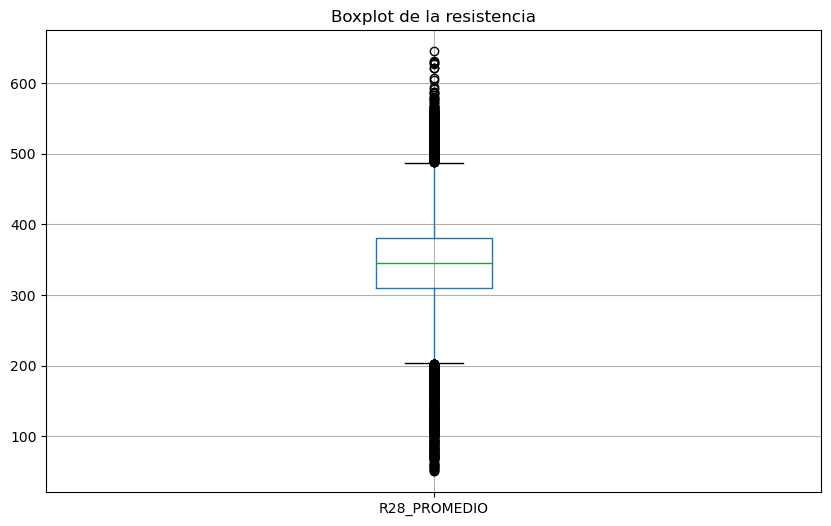

In [112]:
# Boxplot de la resistencia

# Se aprecia que la media es aproximadamente 340, pero hay muchos outliers tanto extremos altos como bajos
df2.boxplot(["R28_PROMEDIO"], figsize=(10, 6))
plt.title("Boxplot de la resistencia")
plt.show()

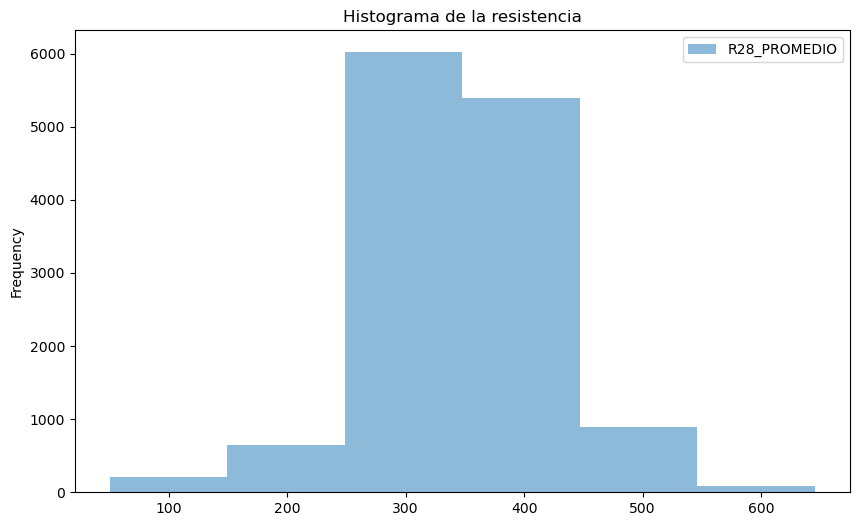

In [113]:
# Bar plot de la resistencia

# Se aprecia visualmente que la resistencia tiende a tener valores menores a la media (la cola izquierda 
# de la distribución es más amplia)
df2[["R28_PROMEDIO"]].plot.hist(alpha=0.5, figsize=(10, 6), bins=6)
plt.title("Histograma de la resistencia")
plt.show()

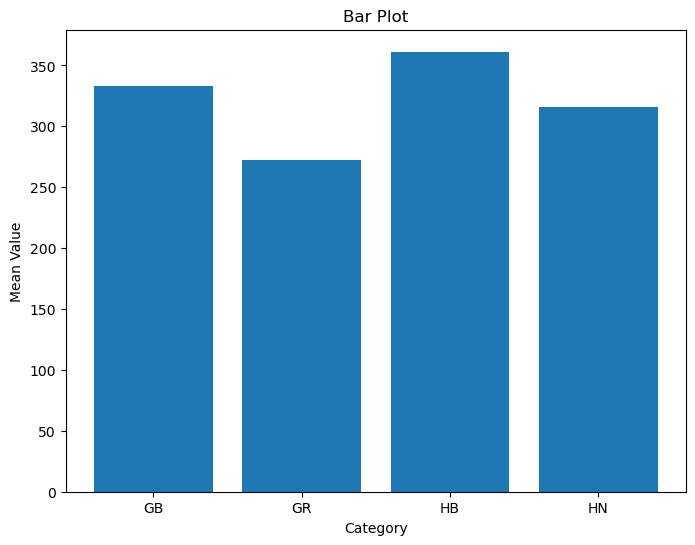

In [114]:
# Relación entre el tipo de concreto y la resistencia promedio en la muestra

# No se aprecia gran variación en la resistencia debido a cambio en el tipo de concreto

mean_values = df2_an.groupby("TIPO_CONCRETO")["R28_PROMEDIO"].mean()
fig = plt.figure(figsize=(8, 6))
plt.bar(mean_values.index, mean_values.values)
plt.xlabel('Category')
plt.ylabel('Mean Value')
plt.title('Bar Plot')
plt.show()

In [116]:
# Se elabora una matriz de correlaciones, se excluyen variables que intuitivamente no serán buenos explicadores
# de la resistencia, por ejemplo el código del despacho, del producto, el código de descripción del producto, etc.

df2_red = df2_an.drop(["CODIGO_GUIA_DESPACHO","CODIGO_PRODUCTO"], axis = 1)

corrmat = round(df2_red.corr(),2)
mask = np.triu(np.ones_like(corrmat, dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True,mask=mask);

In [117]:
# De la matriz de correlaciones se obtienen las 10 variables con correlación más alta con la resistencia en 
# valor absoluto

corr = round(df2.corr(),2)
target_corr = corr["R28_PROMEDIO"]
sorted_corr = target_corr.abs().sort_values(ascending=False)
top_10_vars = sorted_corr[1:11]
index_top = top_10_vars.index

In [118]:
# Se imprimen las 10 variables más correlacionadas con la resistencia. 

target_corr.loc[index_top]

RESISTENCIA_ESPECIFICADA         0.82
CEMENTO_CANTIDAD_CONSUMIDA_M3    0.57
Cemento_CE_MESP                 -0.49
CONO_ABRAMS                      0.31
Tipo_Concreto_HB                 0.30
ARENA_CANTIDAD_CONSUMIDA_M3     -0.30
Tipo_Concreto_HN                -0.29
ADITIVO_CANTIDAD_CONSUMIDA_M3    0.28
Size_XL                          0.24
WATER_CANTIDAD_CONSUMIDA_M3      0.16
Name: R28_PROMEDIO, dtype: float64

In [119]:
# Se hace un scatter matrix con las 4 variables de correlación más alta

target = index_top[:4].tolist() + ["R28_PROMEDIO"]

df_top = df2[target]

pd.plotting.scatter_matrix(df_top,alpha=0.5,figsize=(15,20))

array([[<AxesSubplot:xlabel='RESISTENCIA_ESPECIFICADA', ylabel='RESISTENCIA_ESPECIFICADA'>,
        <AxesSubplot:xlabel='CEMENTO_CANTIDAD_CONSUMIDA_M3', ylabel='RESISTENCIA_ESPECIFICADA'>,
        <AxesSubplot:xlabel='Cemento_CE_MESP', ylabel='RESISTENCIA_ESPECIFICADA'>,
        <AxesSubplot:xlabel='CONO_ABRAMS', ylabel='RESISTENCIA_ESPECIFICADA'>,
        <AxesSubplot:xlabel='R28_PROMEDIO', ylabel='RESISTENCIA_ESPECIFICADA'>],
       [<AxesSubplot:xlabel='RESISTENCIA_ESPECIFICADA', ylabel='CEMENTO_CANTIDAD_CONSUMIDA_M3'>,
        <AxesSubplot:xlabel='CEMENTO_CANTIDAD_CONSUMIDA_M3', ylabel='CEMENTO_CANTIDAD_CONSUMIDA_M3'>,
        <AxesSubplot:xlabel='Cemento_CE_MESP', ylabel='CEMENTO_CANTIDAD_CONSUMIDA_M3'>,
        <AxesSubplot:xlabel='CONO_ABRAMS', ylabel='CEMENTO_CANTIDAD_CONSUMIDA_M3'>,
        <AxesSubplot:xlabel='R28_PROMEDIO', ylabel='CEMENTO_CANTIDAD_CONSUMIDA_M3'>],
       [<AxesSubplot:xlabel='RESISTENCIA_ESPECIFICADA', ylabel='Cemento_CE_MESP'>,
        <AxesSubplot:xlabel=

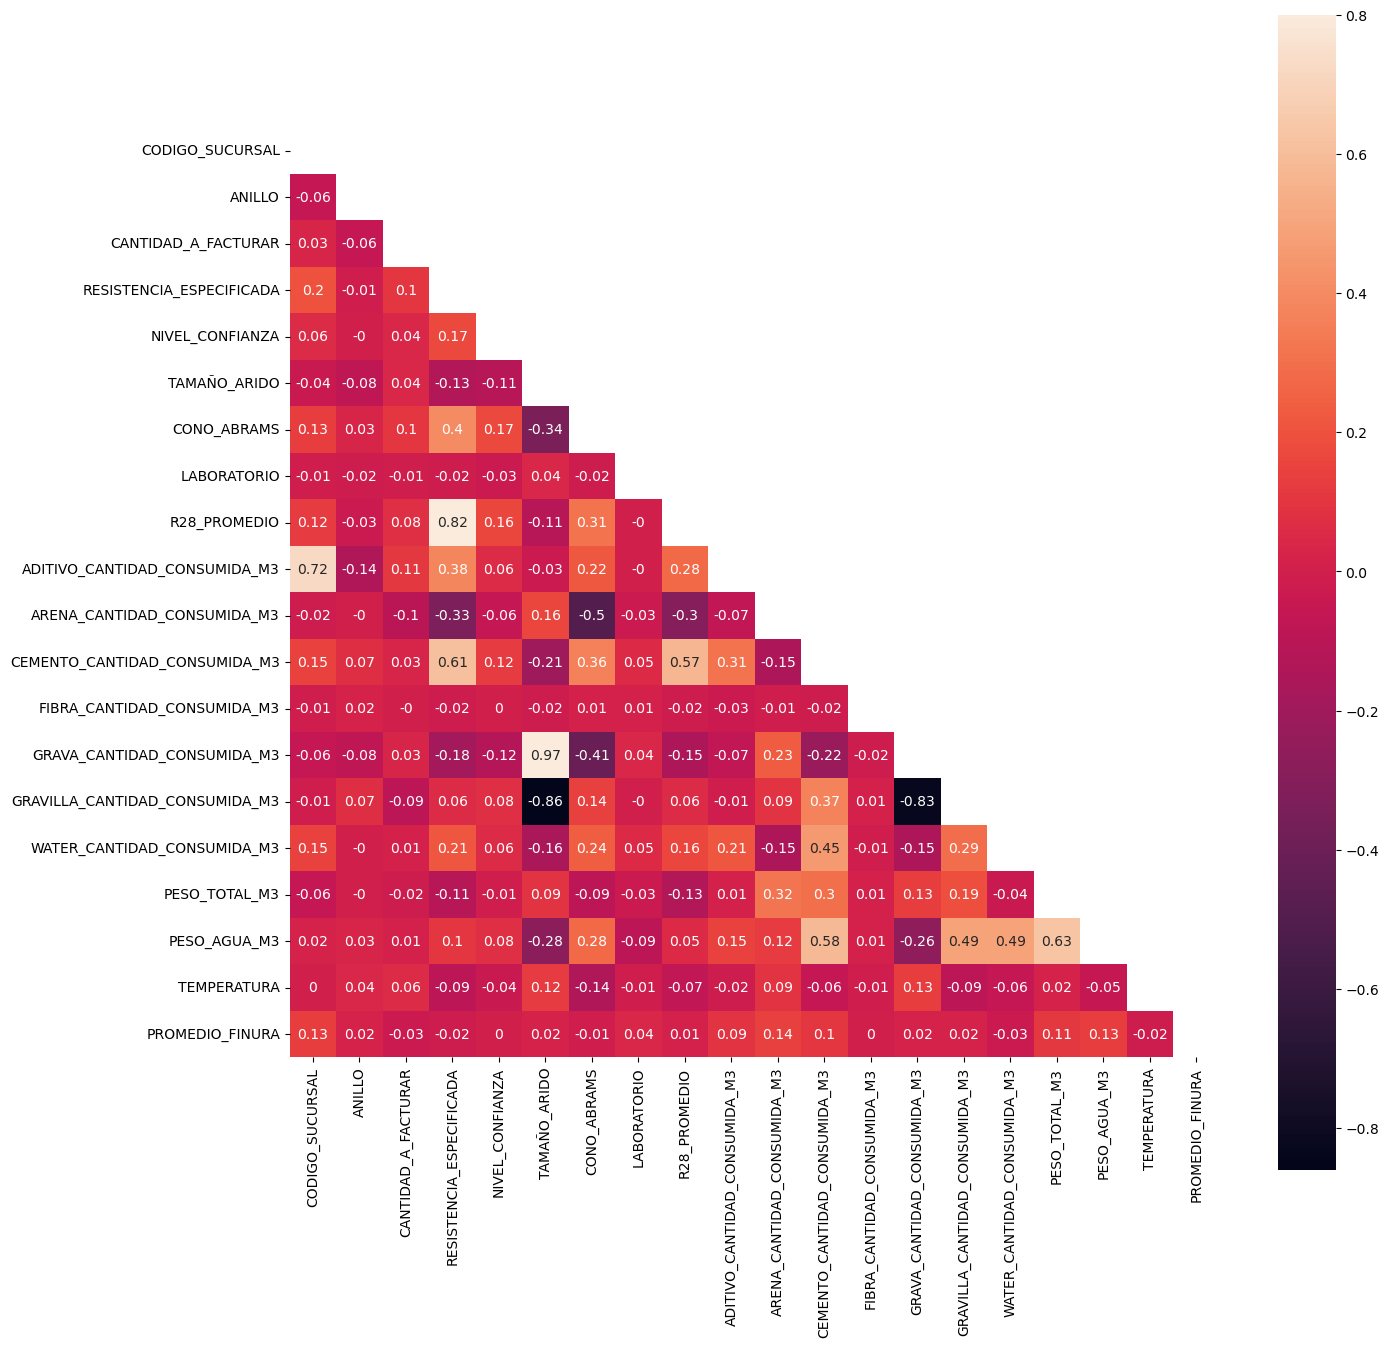

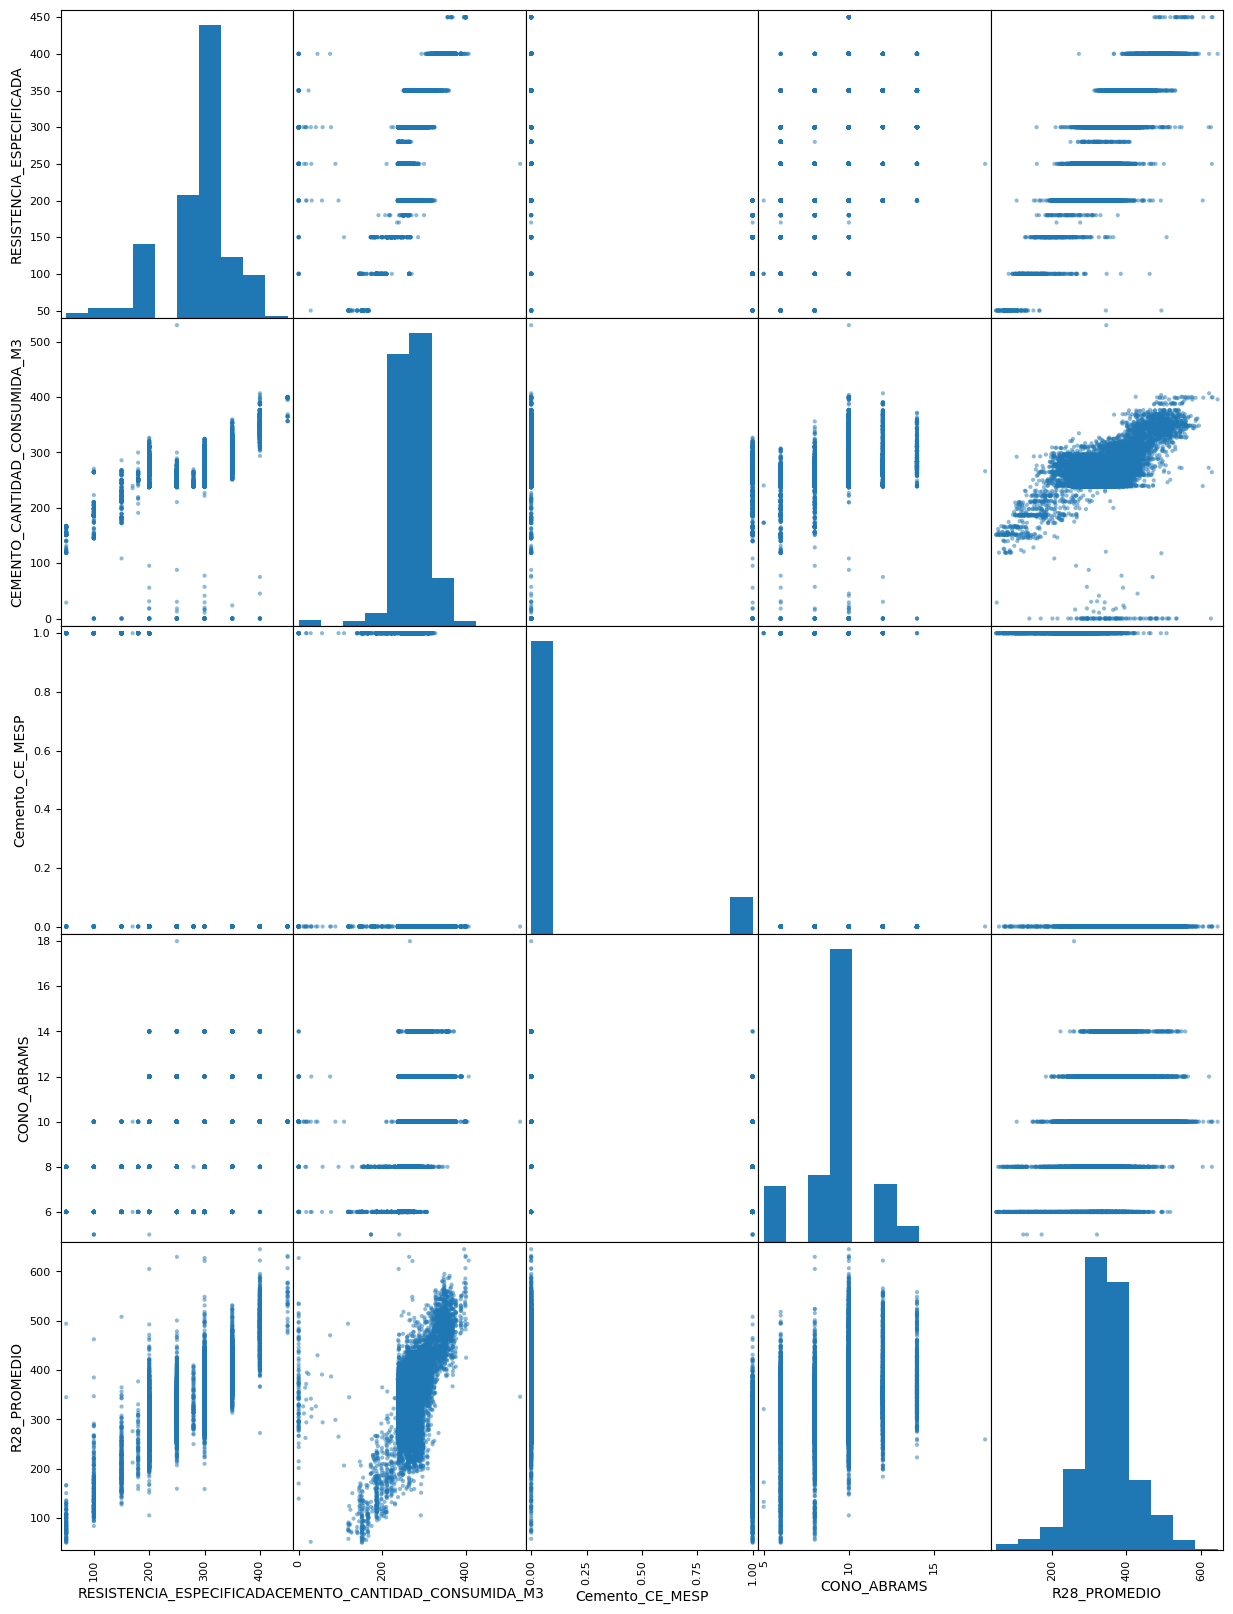

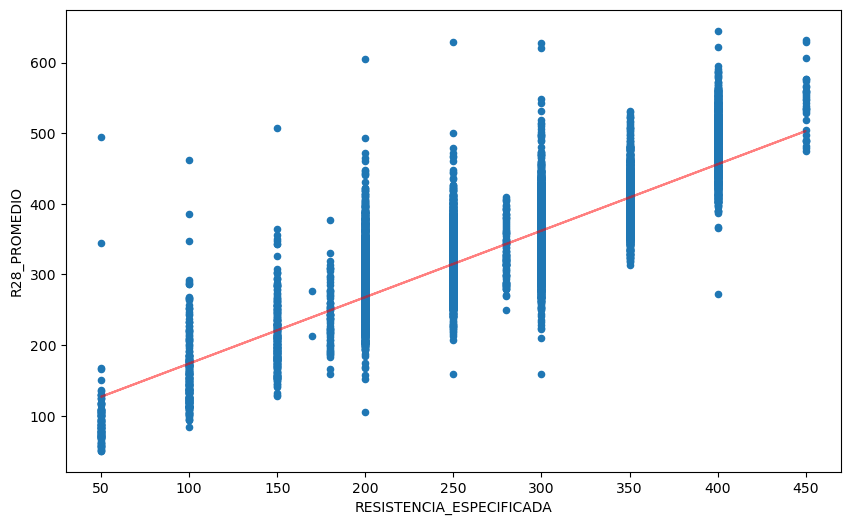

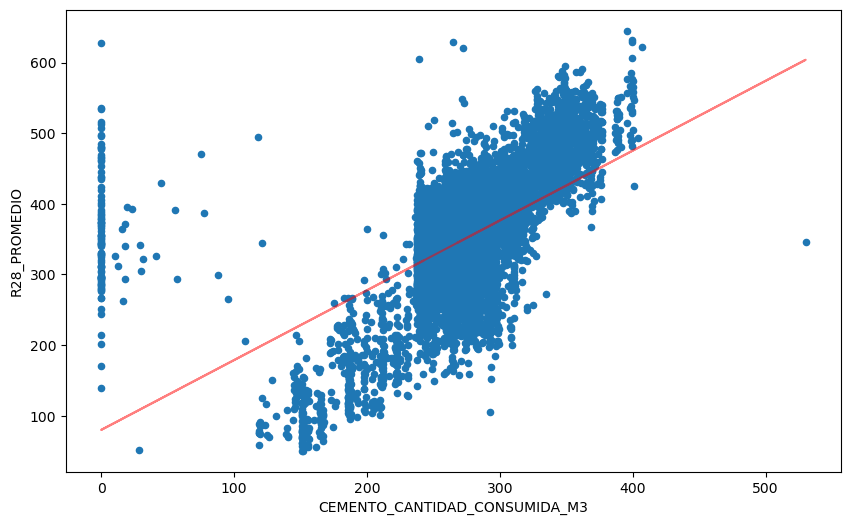

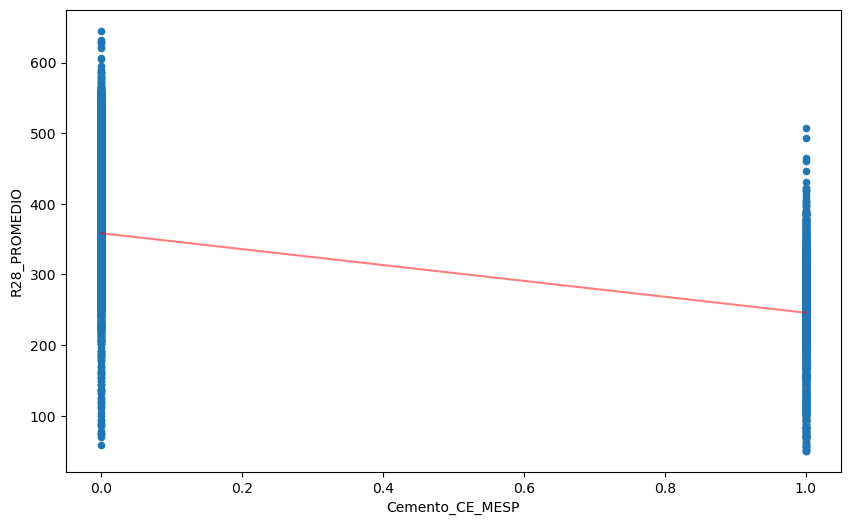

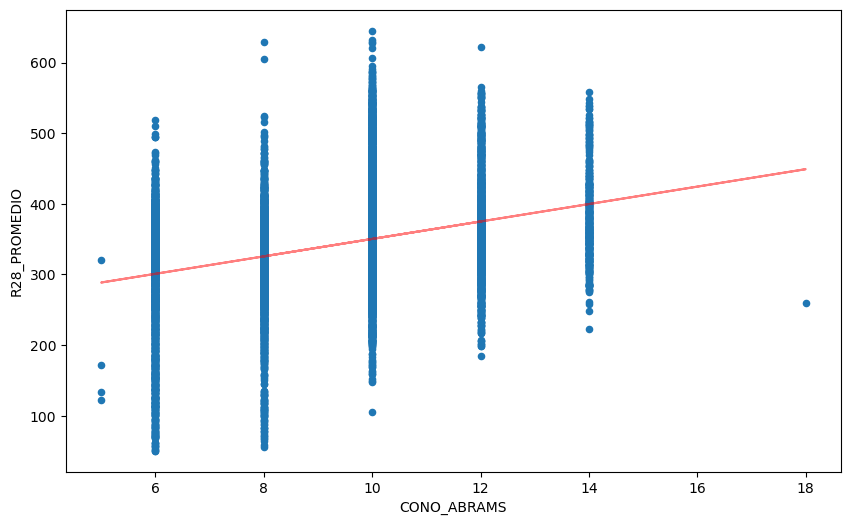

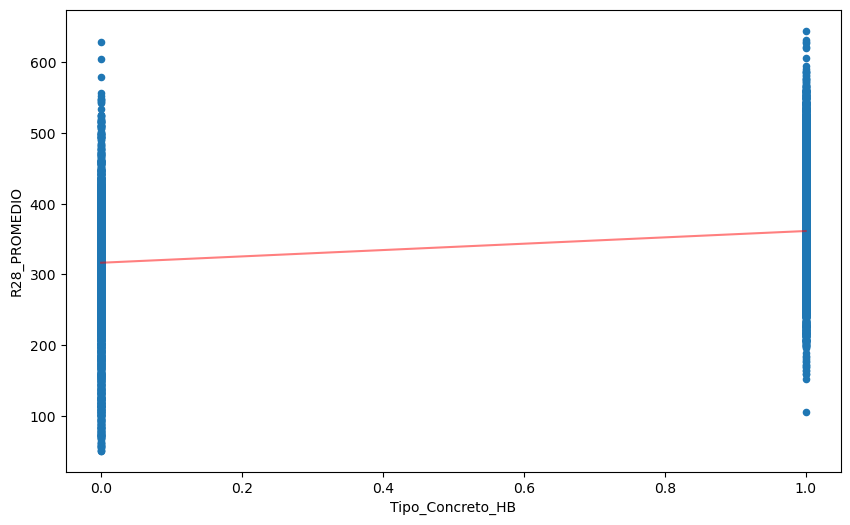

In [120]:
# Se grafica la correlación con línea de predicción de la variable resistencia con las 5 variables de 
# correlación más alta

var_grafico = index_top[:5].tolist()

for var in var_grafico:
    df2.plot.scatter(var,"R28_PROMEDIO",figsize=(10,6))
    reg = LinearRegression()
    X = df2[[var]]
    y = df2["R28_PROMEDIO"]
    reg.fit(X,y)
    y_pred = reg.predict(X)
    plt.plot(X,y_pred,color="red",alpha=0.5)
    plt.show()

Creamos una variable RATIO_RESISTENCIA que es la división entre el R28_PROMEDIO / RESISTENCIA_ESPECIFICADA, para visualizar si se alcanza la RESISTENCIA_ESPECIFICADA en todos los pedidos y, de ser así, en cuánto se pasa la resistencia efectiva (lo que estaría generando sobrecostos)

In [123]:
# Eliminamos dicha variable
df_ratio = df_ratio.drop('PRODUCTO_VAP', axis=1)

# Y las que tienen varios nulos
df_ratio = df_ratio.drop('FIBRA_INSUMO', axis=1)
df_ratio = df_ratio.drop('GRAVA_INSUMO', axis=1)
df_ratio = df_ratio.drop('OTRO_CANTIDAD_CONSUMIDA_M3', axis=1)

# Y la variable DESCRIPCION_PRODUCTO que ya dividimos
df_ratio = df_ratio.drop('DESCRIPCION_PRODUCTO', axis=1)
df_ratio = df_ratio.drop('HORA_CARGA', axis=1)

In [124]:
# Eliminamos las finuras
df_ratio = df_ratio.drop('ARENA_FINURA', axis=1)
df_ratio = df_ratio.drop('GRAVA_FINURA', axis=1)
df_ratio = df_ratio.drop('GRAVILLA_FINURA', axis=1)

In [125]:
# Completamos las cantidades que tienen nulos con ceros
df_ratio['ADITIVO_CANTIDAD_CONSUMIDA_M3'] = df_ratio['ADITIVO_CANTIDAD_CONSUMIDA_M3'].fillna(0)
df_ratio['FIBRA_CANTIDAD_CONSUMIDA_M3'] = df_ratio['FIBRA_CANTIDAD_CONSUMIDA_M3'].fillna(0)
df_ratio['GRAVA_CANTIDAD_CONSUMIDA_M3'] = df_ratio['GRAVA_CANTIDAD_CONSUMIDA_M3'].fillna(0)

In [126]:
# Eliminamos los nulos
df_ratio.dropna(axis=0, inplace=True)

# Luego, reseteamos los índices del DF
df_ratio.reset_index(inplace=True, drop=True)

In [127]:
# Creamos el ratio
df_ratio['RATIO_RESISTENCIA'] = df_ratio.R28_PROMEDIO / df_ratio.RESISTENCIA_ESPECIFICADA

In [128]:
# Nos quedamos solo con la fecha y el ratio
df_ratio = df_ratio[['FECHA_GUIA_DESPACHO', 'RATIO_RESISTENCIA']]


In [129]:
# Se guarda en CSV la tabla main final en la ruta
df_ratio.to_csv(ruta + "_Ratio_Resistencia.csv", index = False)

## 3. Modelos

In [130]:
# Cargar base pre procesada
df = pd.read_csv('/Users/valerie/Desktop/Data/CAA_AP_TABLA_Base_final.csv')

In [131]:
# Eliminamos los nulos
df.dropna(axis=0, inplace=True)

# Luego, reseteamos los índices del DF
df.reset_index(inplace=True, drop=True)

In [132]:
# Variables con valores nulos
df.dtypes

CODIGO_GUIA_DESPACHO                int64
CODIGO_PRODUCTO                     int64
CODIGO_SUCURSAL                     int64
ANILLO                              int64
CANTIDAD_A_FACTURAR               float64
TAMANO                             object
TIPO_CONCRETO                      object
RESISTENCIA_ESPECIFICADA            int64
NIVEL_CONFIANZA                     int64
TAMAÑO_ARIDO                        int64
CONO_ABRAMS                         int64
LABORATORIO                       float64
R28_PROMEDIO                      float64
ADITIVO_INSUMO                     object
ARENA_INSUMO                       object
CEMENTO_INSUMO                     object
GRAVILLA_INSUMO                    object
ADITIVO_CANTIDAD_CONSUMIDA_M3     float64
ARENA_CANTIDAD_CONSUMIDA_M3       float64
CEMENTO_CANTIDAD_CONSUMIDA_M3     float64
FIBRA_CANTIDAD_CONSUMIDA_M3       float64
GRAVA_CANTIDAD_CONSUMIDA_M3       float64
GRAVILLA_CANTIDAD_CONSUMIDA_M3    float64
WATER_CANTIDAD_CONSUMIDA_M3       

In [133]:
df['NIVEL_CONFIANZA'].value_counts()

90    11651
80      154
95       11
85        1
Name: NIVEL_CONFIANZA, dtype: int64

In [134]:
# Convertir a dummies las variables categóricas no ordenadas
df = pd.get_dummies(df, columns=['TAMANO', 'TIPO_CONCRETO', 'ADITIVO_INSUMO', 'ARENA_INSUMO', 
                                 'CEMENTO_INSUMO','GRAVILLA_INSUMO','CODIGO_SUCURSAL' ], drop_first=True)

In [135]:
# Vemos el tamaño del df
df.shape

(11817, 59)

Separamos la data en train y test

In [136]:
# Generar matriz de diseño y vector target
# Quitamos los IDs de los despachos ya que no aportan valor predictivo
# Y la resistencia especificada por el cliente, ya que no impacta directamente en la resistencia, sino a través de cómo se hace la mezcla del hormigón
X = df.drop(['R28_PROMEDIO', 'LABORATORIO', 'CODIGO_GUIA_DESPACHO', 'CODIGO_PRODUCTO', 'RESISTENCIA_ESPECIFICADA'], axis=1)
y = df.R28_PROMEDIO

In [137]:
# Generar conjunto de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ahora, aplicamos los siguientes modelos:

### 3.1. Linear Regression

In [140]:
# Se corre una regresión lineal múltiple considerando todas las variables excepto aquellas que intuitivamente
# no explican la resistencia, como el código del despacho

# Las variables que no se incluyen son:

# 1. CODIGO_GUIA_DESPACHO 
# 2. FECHA_GUIA_DESPACHO
# 3. CODIGO_PRODUCTO 
# 4. DESCRIPCION_PRODUCTO
# 5. HORA_CARGA

cols_to_exclude = ["CODIGO_PRODUCTO", "R28_PROMEDIO"]
X = df2.drop(columns = cols_to_exclude)
X = sm.add_constant(X)
y = df2["R28_PROMEDIO"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           R28_PROMEDIO   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     517.0
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:50:59   Log-Likelihood:                -53388.
No. Observations:               10607   AIC:                         1.069e+05
Df Residuals:                   10550   BIC:                         1.073e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [141]:
# Se evalúa la capacidad predictiva del modelo lineal múltiple sin modificaciones 

# Para los datos train
y_predicho = results.predict(X_train)
mae_train = mean_absolute_error(y_train, y_predicho)

# Para los datos test
y_predicho_test = results.predict(X_test)
mae_test = mean_absolute_error(y_test, y_predicho_test)

Aplicando mejoras al modelo de regresión lineal múltiple: VIF y distancia de Cook

In [142]:
# Se calcula el VIF de las explicativas para evaluar problemas de multicolinealidad

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif[vif["Variable"] != "const"]
vif = vif.sort_values(by = "VIF", ascending = False)
vif = vif[vif["VIF"] > 10]
vif = vif.head(3)
print(X.shape)
print(vif)

(13259, 58)
                       Variable        VIF
56          Gravilla_GL_MEL-PSB  72.486464
57            Gravilla_GL_MELST  60.805242
12  GRAVA_CANTIDAD_CONSUMIDA_M3  40.739828


In [143]:
# Se eliminan las 3 variables cuyo VIF es más elevado y mayor a 10

excluded_var = vif["Variable"].values
X = X.drop(columns = excluded_var, axis = 1)
X.shape

(13259, 55)

In [144]:
# Se calcula la distancia de Cook para identificar outliers. 

influence = results.get_influence()
cooks_distance = influence.cooks_distance[0]

cooks_df = pd.DataFrame({'Observation': X_train.index, 'Cook\'s Distance': cooks_distance})
cooks_df['Cook\'s Distance'] = cooks_df['Cook\'s Distance'].round(2)
cooks_df = cooks_df[cooks_df["Cook\'s Distance"] > 1]
X.shape

(13259, 55)

In [145]:
# Se eliminan las observaciones cuya Distancia de Cook es mayor a 1

filtered_obs = cooks_df["Observation"].values
X = X.drop(filtered_obs)
y = y.drop(filtered_obs)
X.shape

(13258, 55)

In [147]:
# Se eliminan las variables cuyo p-value es mayor a 0.05 

high_p_values = 'CANTIDAD_A_FACTURAR'

X = X.drop(columns = high_p_values)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           R28_PROMEDIO   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     517.0
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:52:36   Log-Likelihood:                -53388.
No. Observations:               10607   AIC:                         1.069e+05
Df Residuals:                   10550   BIC:                         1.073e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            214.0100     33.389      6.410      0.000     148.561     279.459
CODIGO_GUIA_DESPACHO           -2.909e-06   8.35e-07     -3.484      0.000   -4.55e-06   -1.27e-06
ANILLO                            -0.0308      0.005     -6.266      0.000      -0.040      -0.021
CANTIDAD_A_FACTURAR                0.4192      0.440      0.953      0.341      -0.443       1.281
RESISTENCIA_ESPECIFICADA           0.4330      0.015     28.217      0.000       0.403       0.463
NIVEL_CONFIANZA                    0.8018      0.332      2.415      0.016       0.151       1.453
TAMAÑO_ARIDO                      -1.4308      0.218     -6.572      0.000      -1.858      -1.004
CONO_ABRAMS                       -1.8559      0.319     -5.811      0.000      -2.482      -1.230
ADITIVO_CANTIDAD_CONSUMIDA_M3     -0.0085      0.003     -3.138      0.002      -0.014      -0.003
ARENA_CANTIDAD_CONSUMIDA_M3       -0.0169      0.004     -4.724      0.000      -0.024      -0.010
CEMENTO_CANTIDAD_CONSUMIDA_M3      1.0773      0.028     38.969      0.000       1.023       1.131
FIBRA_CANTIDAD_CONSUMIDA_M3        0.2480      0.721      0.344      0.731      -1.165       1.661
GRAVA_CANTIDAD_CONSUMIDA_M3       -0.0767      0.011     -7.159      0.000      -0.098      -0.056
GRAVILLA_CANTIDAD_CONSUMIDA_M3    -0.1730      0.012    -14.225      0.000      -0.197      -0.149
WATER_CANTIDAD_CONSUMIDA_M3       -0.3316      0.032    -10.519      0.000      -0.393      -0.270
PESO_TOTAL_M3                     -0.0275      0.003     -9.626      0.000      -0.033      -0.022
PESO_AGUA_M3                      -0.2591      0.046     -5.620      0.000      -0.349      -0.169
TEMPERATURA                        0.1310      0.112      1.168      0.243      -0.089       0.351
PROMEDIO_FINURA                    0.5831      0.194      3.013      0.003       0.204       0.963
Sucursal_111                     -17.2856      3.072     -5.627      0.000     -23.307     -11.264
Sucursal_121                     -16.8699      3.991     -4.227      0.000     -24.693      -9.047
Sucursal_122                     -22.8470      4.628     -4.936      0.000     -31.919     -13.775
Sucursal_123                     -22.2337      3.898     -5.704      0.000     -29.875     -14.592
Sucursal_131                     -21.1510      4.893     -4.322      0.000     -30.743     -11.559
Sucursal_132                     -21.5297      4.908     -4.387      0.000     -31.150     -11.909
Sucursal_133                      -8.8928      5.292     -1.680      0.093     -19.266       1.481
Sucursal_151                     -32.4019      5.018     -6.457      0.000     -42.239     -22.565
Size_M                             0.2768      1.080      0.256      0.798      -1.840       2.394
Size_ME       

In [148]:
# Se vuelve a correr el modelo de regresión linear múltiple con los cambios realizados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model_mod = sm.OLS(y_train, X_train)
results_mod = model_mod.fit()

print(results_mod.summary())

                            OLS Regression Results                            
Dep. Variable:           R28_PROMEDIO   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     550.8
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:52:42   Log-Likelihood:                -53518.
No. Observations:               10606   AIC:                         1.071e+05
Df Residuals:                   10554   BIC:                         1.075e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [149]:
# Se evalúa la capacidad predictiva del modelo lineal múltiple con modificaciones

# Para la data train 
y_predicho_train = results_mod.predict(X_train)
mae_mod_train = mean_absolute_error(y_predicho_train, y_train)

# Para la data test
y_predicho_test = results_mod.predict(X_test)
mae_mod_test = mean_absolute_error(y_predicho_test, y_test)

Aplicando validación cruzada al modelo lineal múltiple

In [158]:
# Se define una función la cual incorpora como variables explicativas las variables numéricas elevadas al número hasta "degree" y sus interacciones
# Luego se aplica validación cruzada mediante 5 fold cross validation para determinar el MAE

X_num    = X[['ANILLO', 'RESISTENCIA_ESPECIFICADA', 'NIVEL_CONFIANZA', 'CONO_ABRAMS', 'ADITIVO_CANTIDAD_CONSUMIDA_M3',
       'ARENA_CANTIDAD_CONSUMIDA_M3', 'CEMENTO_CANTIDAD_CONSUMIDA_M3', 'GRAVILLA_CANTIDAD_CONSUMIDA_M3', 'WATER_CANTIDAD_CONSUMIDA_M3', 
       'PESO_TOTAL_M3', 'PESO_AGUA_M3']]
X_dummy  = X.drop(columns = ['ANILLO', 'RESISTENCIA_ESPECIFICADA', 'NIVEL_CONFIANZA', 'CONO_ABRAMS', 'ADITIVO_CANTIDAD_CONSUMIDA_M3',
       'ARENA_CANTIDAD_CONSUMIDA_M3', 'CEMENTO_CANTIDAD_CONSUMIDA_M3', 'GRAVILLA_CANTIDAD_CONSUMIDA_M3', 'WATER_CANTIDAD_CONSUMIDA_M3', 
       'PESO_TOTAL_M3','PESO_AGUA_M3'])
index = X.index

def polynomials(degree):

  poly = PolynomialFeatures(degree)
  X_poly = poly.fit_transform(X_num)
  X_poly = pd.DataFrame(X_poly, index = index)
  X = pd.merge(X_poly, X_dummy, left_index = True, right_index= True)
 
  lm = LinearRegression()

  mae_5cv = -np.mean(cross_val_score(lm,X_poly,y,scoring='neg_mean_absolute_error',cv=5)) #El 5 fold es un caso especial del LOOCV cuando k=5

  return(mae_5cv)

In [160]:
# Se muestra el MAE obtenido para el grado de polinomio 1, 2 y 3

maes_5cv = [polynomials(1), polynomials(2), polynomials(3)]
degrees  = [1,2,3]

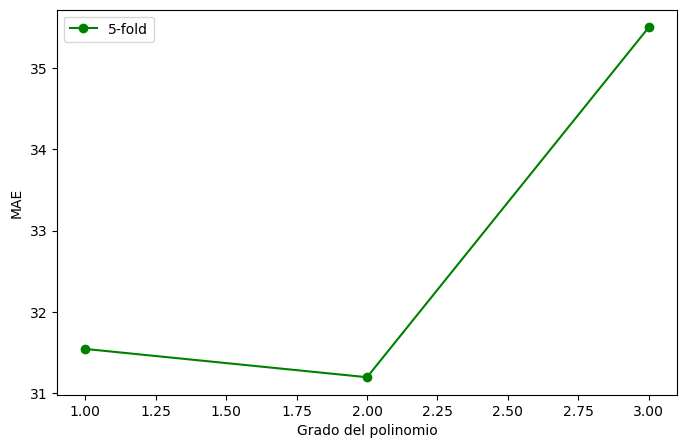

In [223]:
# Se aprecia claramente que el MAE aumenta de forma drástica al llegar al tercer grado de polinomio, por ello no se intenta elevar las explicativas
# a grados adicionales más allá de 3

plt.figure(figsize=(8,5))
plt.plot(degrees, maes_5cv,'o-',c='green',label='5-fold')
plt.ticklabel_format(style='plain')
plt.xlabel('Grado del polinomio')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [162]:
# Se define el "degree" del polinomio óptimo como aquél que logra el menor valor del MAE
min_index = np.argmin(maes_5cv)
pol_optimo = min_index + 1

In [163]:
# Se aplica el modelo con la transformación polinómica óptima hallada mediante validación cruzada

poly = PolynomialFeatures(pol_optimo)
X_poly = poly.fit_transform(X_num)
X_poly = pd.DataFrame(X_poly, index = index)
X = pd.merge(X_poly, X_dummy, left_index = True, right_index= True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model_5cv = sm.OLS(y_train, X_train)
results_5cv = model_5cv.fit()

In [164]:
# Se evalúan la capacidad predictiva del modelo

# Para la data train 
y_predicho_train_5cv = results_5cv.predict(X_train)
mae_5cv_train = mean_absolute_error(y_predicho_train_5cv, y_train)

# Para la data test
y_predicho_test_5cv = results_5cv.predict(X_test)
mae_5cv_test = mean_absolute_error(y_predicho_test_5cv, y_test)

In [165]:
# Se comparan los resultados de los modelos lineales correspondientes

table_data = [
    ["Modelo", "MAE_Train","MAE_Test"],
    ["Lineal Múltiple", mae_train, mae_test],
    ["Lineal Múltiple con Modificaciones", mae_mod_train, mae_mod_test],
    ["Lineal Múltiple con 5 fold CV", mae_5cv_train, mae_5cv_test]
]
print(tabulate(table_data, headers="firstrow"))

Modelo                                MAE_Train    MAE_Test
----------------------------------  -----------  ----------
Lineal Múltiple                         28.524      29.8936
Lineal Múltiple con Modificaciones      28.8884     29.5971
Lineal Múltiple con 5 fold CV           27.6205     28.2716


### 3.2. PCA Regression

In [181]:
# Cargar base pre procesada
df = pd.read_csv('/Users/valerie/Desktop/Data/CAA_AP_TABLA_Base_final.csv')

In [182]:
# Eliminamos los nulos
df.dropna(axis=0, inplace=True)

# Luego, reseteamos los índices del DF
df.reset_index(inplace=True, drop=True)

In [183]:
# Convertir a dummies las variables categóricas no ordenadas
df = pd.get_dummies(df, columns=['TAMANO', 'TIPO_CONCRETO', 'ADITIVO_INSUMO', 'ARENA_INSUMO', 
                                 'CEMENTO_INSUMO','GRAVILLA_INSUMO','CODIGO_SUCURSAL' ], drop_first=True)

In [184]:
# Generar matriz de diseño y vector target
# Quitamos los IDs de los despachos ya que no aportan valor predictivo
# Y la resistencia especificada por el cliente, ya que no impacta directamente en la resistencia, sino a través de cómo se hace la mezcla del hormigón
X = df.drop(['R28_PROMEDIO', 'LABORATORIO', 'CODIGO_GUIA_DESPACHO', 'CODIGO_PRODUCTO', 'RESISTENCIA_ESPECIFICADA'], axis=1)
y = df.R28_PROMEDIO

In [185]:
# Generar conjunto de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [186]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

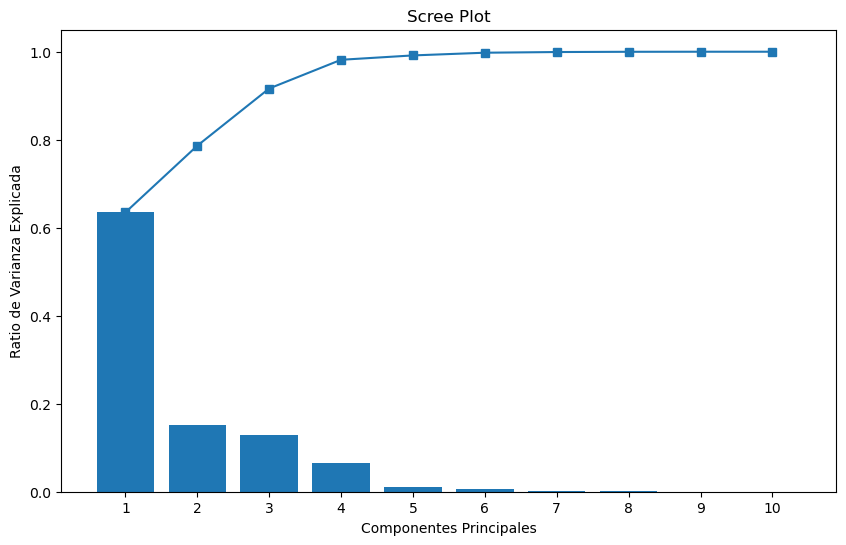

In [187]:
# Graficar el Scree Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10])
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), marker="s")
plt.xticks(range(1, 11))
plt.title("Scree Plot")
plt.xlabel("Componentes Principales")
plt.ylabel("Ratio de Varianza Explicada")
plt.show()

In [188]:
model_pcr = LinearRegression()
model_pcr.fit(X_train_pca[:,:9], y_train)
y_pred =model_pcr.predict(X_test_pca[:,:9])

In [189]:
# El MAE de este modelo es:
mae_PCA = mean_absolute_error(y_test, y_pred)
print("El MAE del Principal Component Regression es:", mae_PCA)

El MAE del Principal Component Regression es: 37.34485026630681


### 3.3. Lasso Regression

In [190]:
# Se evalúan varias valores de lambda
lasso = LassoCV(alphas = np.arange(0.1, 10, 0.1), cv = 10, max_iter = 5000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

Correlación: 0.8500
MAE: 29.4547
Mejor lambda: 0.1000



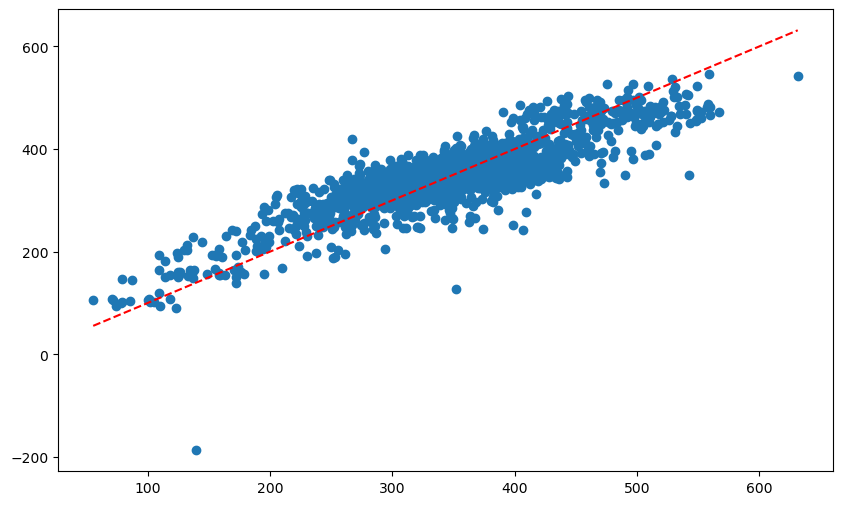

In [191]:
# Metricas de desempenho del modelo
lasso_ans_corr = pearsonr(y_test, y_pred)[0]
lasso_ans_mae = mean_absolute_error(y_test, y_pred)
lasso_ans_lambda = lasso.alpha_
print(f"Correlación: {lasso_ans_corr:.4f}")
print(f"MAE: {lasso_ans_mae:.4f}")
print(f"Mejor lambda: {lasso_ans_lambda:.4f}")
print()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--')
plt.savefig('CorrLasso.jpg', format='jpg') # Guardar el gráfico en un archivo jpg
plt.show()


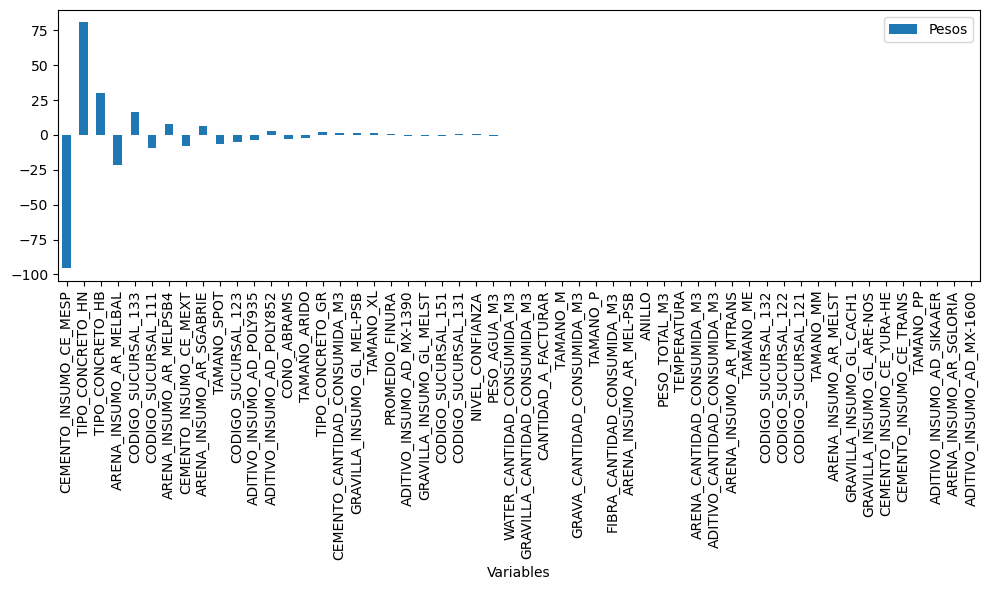

In [192]:
# Visualizamos los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lasso.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (10, 6))

plt.tight_layout()
# Guardar el gráfico en un archivo JPG
plt.savefig('pesosLasso.jpg', format='jpg')

plt.show()

### 3.4. Tree Regression

In [193]:
# Generar grilla y score
tree_grid = {"max_depth": np.arange(1, 15, 1)}
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [194]:
# Utilizar gridsearch y cross validation para
clf = GridSearchCV(estimator = DecisionTreeRegressor(),
                   param_grid = tree_grid,
                   scoring = scorer,
                   cv = 5,
                   n_jobs = -1)
clf_fit = clf.fit(X_train,y_train)

In [195]:
# Se muestra la mejor profundidad y el mejor criterio de decision
print("Mejor profundidad:", clf_fit.best_params_["max_depth"])

Mejor profundidad: 8


In [196]:
# Se entrena el modelo con los mejores parametros identificados
tree = DecisionTreeRegressor(
  max_depth = clf_fit.best_params_["max_depth"],
  random_state = 42)
tree_fit = tree.fit(X_train, y_train)

In [197]:
# Prediccion
y_pred = tree_fit.predict(X_test)

In [198]:
# Mostramos el MAE de tree regression
mae_tree = mean_absolute_error(y_test, y_pred)
print("MAE Tree Regression:", round(mae_tree, 4))

MAE Tree Regression: 30.1311


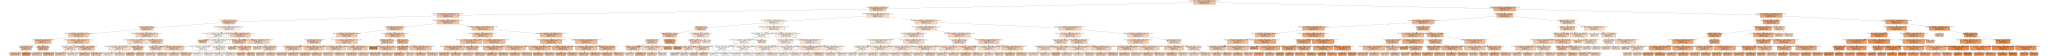

In [199]:
# Visualizamos el árbol de decisión
export_graphviz(tree_fit,
                out_file = 'tree.dot',
                feature_names = X.columns,
                class_names = ['No','Yes'],
                rounded = True,
                filled = True)
with open('tree.dot') as f:
  dot_graph = f.read()
Source(dot_graph)

### 3.5. Random Forest

In [200]:
# Grilla en la búsqueda
forest_grid = {
  "n_estimators": np.arange(30, 37, 1),
  "max_depth": np.arange(14, 22, 1)
}
# Construyo un scorer AdHoc ya que evaluaran nuestro modelo en base al MAE
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Aplicamos GridSeach para evaluar distintos valores de los hiperparametros
clf = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = forest_grid,
    cv = 5, scoring = scorer,
    n_jobs = -1 )

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([14, 15, 16, 17, 18, 19, 20, 21]),
                         'n_estimators': array([30, 31, 32, 33, 34, 35, 36])},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [201]:
print("Mejor número de estimadores:", clf.best_params_["n_estimators"])
print("Mejor profundidad:", clf.best_params_["max_depth"])

Mejor número de estimadores: 36
Mejor profundidad: 17


In [202]:
# Aplicamos RandomForest con los valores de hiperparámetros ideales
forest_model = RandomForestRegressor(
  n_estimators = clf.best_params_["n_estimators"],
  max_depth = clf.best_params_["max_depth"],
  random_state = 42
)
forest_fit = forest_model.fit(X_train, y_train)

In [203]:
# Realizamos predicciones
forest_y_pred = forest_model.predict(X_test)

In [204]:
# Calcula el MAE
mae_RandomForest = mean_absolute_error(y_test, forest_y_pred)
print("MAE Random Forest:", round(mae_RandomForest, 4))

MAE Random Forest: 27.5051


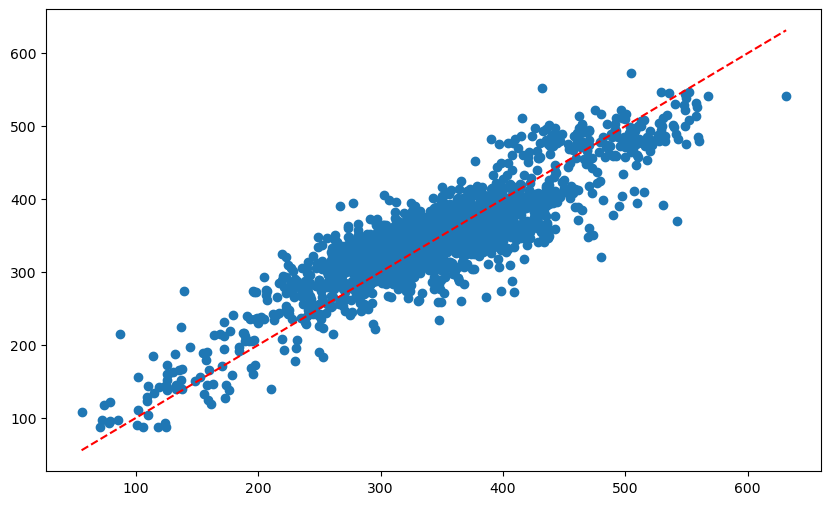

In [205]:
# Metricas de desempenho del modelo
plt.figure(figsize=(10, 6))
plt.scatter(y_test, forest_y_pred)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--')
plt.savefig('corrRandom.jpg', format='jpg') # Guardar el gráfico en un archivo jpg
plt.show()


## 4. Predicción de los despachos de la Tabla 7

Primero, tenemos que crear nuestras X's con las filas que vamos a usar según los despachos indicados en la Tabla 7

In [206]:
# Para ello, cargamos la base preprocesada en la base que va a contener las X's de los códigos de despacho de la Tabla 7
X_df7 = pd.read_csv('/Users/valerie/Desktop/Data/CAA_AP_TABLA_Base_final.csv')

Ahora, seguimos los mismos pasos que hicimos al inicio de este bloque para obtener el df final con los Xs de los despachos de la tabla 7

In [207]:
# Convertir a dummies las variables categóricas no ordenadas
X_df7 = pd.get_dummies(X_df7, columns=['TAMANO', 'TIPO_CONCRETO', 'ADITIVO_INSUMO', 'ARENA_INSUMO', 
                                       'CEMENTO_INSUMO','GRAVILLA_INSUMO','CODIGO_SUCURSAL' ], drop_first=True)

In [208]:
# Verificamos que df y X_df7 tengan las mismas columnas
columnas_comunes = list(set(df.columns).intersection(X_df7.columns))

# Obtener las columnas adicionales en X_df7
columnas_adicionales = list(set(X_df7.columns) - set(df.columns))

# Dropear las columnas adicionales en X_df7
X_df7 = X_df7.drop(columnas_adicionales, axis=1)

In [209]:
# Filtramos las filas para que queden solo las que están en el df7
X_df7 = X_df7[X_df7['CODIGO_GUIA_DESPACHO'].isin(df7['CODIGO_GUIA_DESPACHO'])]

In [210]:
# Verificamos qué valores debemos completar
print(X_df7.isnull().sum())

CODIGO_GUIA_DESPACHO                0
CODIGO_PRODUCTO                     0
ANILLO                              0
CANTIDAD_A_FACTURAR                 0
RESISTENCIA_ESPECIFICADA            0
NIVEL_CONFIANZA                     0
TAMAÑO_ARIDO                        0
CONO_ABRAMS                         0
LABORATORIO                       591
R28_PROMEDIO                      591
ADITIVO_CANTIDAD_CONSUMIDA_M3       0
ARENA_CANTIDAD_CONSUMIDA_M3         0
CEMENTO_CANTIDAD_CONSUMIDA_M3       0
FIBRA_CANTIDAD_CONSUMIDA_M3         0
GRAVA_CANTIDAD_CONSUMIDA_M3         0
GRAVILLA_CANTIDAD_CONSUMIDA_M3      0
WATER_CANTIDAD_CONSUMIDA_M3         0
PESO_TOTAL_M3                       0
PESO_AGUA_M3                        0
TEMPERATURA                         0
PROMEDIO_FINURA                    29
TAMANO_M                            0
TAMANO_ME                           0
TAMANO_MM                           0
TAMANO_P                            0
TAMANO_PP                           0
TAMANO_SPOT 

In [211]:
# Completamos PROMEDIO_FINURA con la mediana de la columna (valor no afecto a los valores extremos)
X_df7['PROMEDIO_FINURA'].fillna(X_df7['PROMEDIO_FINURA'].median(), inplace=True)

# Verificar los valores nulos después de llenarlos
print(X_df7.isnull().sum())

CODIGO_GUIA_DESPACHO                0
CODIGO_PRODUCTO                     0
ANILLO                              0
CANTIDAD_A_FACTURAR                 0
RESISTENCIA_ESPECIFICADA            0
NIVEL_CONFIANZA                     0
TAMAÑO_ARIDO                        0
CONO_ABRAMS                         0
LABORATORIO                       591
R28_PROMEDIO                      591
ADITIVO_CANTIDAD_CONSUMIDA_M3       0
ARENA_CANTIDAD_CONSUMIDA_M3         0
CEMENTO_CANTIDAD_CONSUMIDA_M3       0
FIBRA_CANTIDAD_CONSUMIDA_M3         0
GRAVA_CANTIDAD_CONSUMIDA_M3         0
GRAVILLA_CANTIDAD_CONSUMIDA_M3      0
WATER_CANTIDAD_CONSUMIDA_M3         0
PESO_TOTAL_M3                       0
PESO_AGUA_M3                        0
TEMPERATURA                         0
PROMEDIO_FINURA                     0
TAMANO_M                            0
TAMANO_ME                           0
TAMANO_MM                           0
TAMANO_P                            0
TAMANO_PP                           0
TAMANO_SPOT 

In [212]:
# Nos aseguramos que las guías de despacho de X_df7 están en el mismo orden que las de la Tabla 7
# Para ello, creamos un diccionario de mapeo con el orden de df7
orden_df7 = {valor: indice for indice, valor in enumerate(df7['CODIGO_GUIA_DESPACHO'])}

# Luego, creamos una nueva columna "orden" en X_df7 basada en el orden de df7
X_df7['orden'] = X_df7['CODIGO_GUIA_DESPACHO'].map(lambda x: orden_df7.get(x))

# Ordenamos el X_df7 según la columna "orden"
X_df7 = X_df7.sort_values(by='orden')

# Eliminamos la columna "orden" 
X_df7 = X_df7.drop('orden', axis=1)

In [213]:
# Eliminamos las columna de las Y's ['R28_PROMEDIO'] y LABORATORIO, valor que no contamos para los pedidos especificados a predecir
X_df7 = X_df7.drop(['R28_PROMEDIO', 'LABORATORIO'], axis=1)

# Quitamos los IDs de los despachos ya que no aportan valor predictivo
X_df7 = X_df7.drop(['CODIGO_GUIA_DESPACHO', 'CODIGO_PRODUCTO'], axis=1)

Para la predicción, decimos quedarnos con PRECISION_ESPECIFICADA, que, si bien no es muy útil para entender qué insumos o facotes influyen en la resistencia del concreto, hemos visto que es uno de los features que mejora el MAE de la predicción. 

Elegimos el modelo de Random Forest para hallar las resistencias predichas de los despachos del df7. Para ello, lo volvemos a correr usando PRECISION_ESPECIFICADA como feature.

In [214]:
# Generar matriz de diseño y vector target
# Quitamos los IDs de los despachos ya que no aportan valor predictivo
# Y la resistencia especificada por el cliente, ya que no impacta directamente en la resistencia, sino a través de cómo se hace la mezcla del hormigón
X = df.drop(['R28_PROMEDIO', 'LABORATORIO', 'CODIGO_GUIA_DESPACHO', 'CODIGO_PRODUCTO'], axis=1)
y = df.R28_PROMEDIO

In [215]:
# Generar conjunto de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
# Grilla en la búsqueda
forest_grid = {
  "n_estimators": np.arange(30, 37, 1),
  "max_depth": np.arange(14, 22, 1)
}
# Construyo un scorer AdHoc ya que evaluaran nuestro modelo en base al MAE
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Aplicamos GridSeach para evaluar distintos valores de los hiperparametros
clf = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = forest_grid,
    cv = 5, scoring = scorer,
    n_jobs = -1 )

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([14, 15, 16, 17, 18, 19, 20, 21]),
                         'n_estimators': array([30, 31, 32, 33, 34, 35, 36])},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [217]:
print("Mejor número de estimadores:", clf.best_params_["n_estimators"])
print("Mejor profundidad:", clf.best_params_["max_depth"])

Mejor número de estimadores: 34
Mejor profundidad: 20


In [218]:
# Aplicamos RandomForest con los valores de hiperparámetros ideales
forest_model = RandomForestRegressor(
  n_estimators = clf.best_params_["n_estimators"],
  max_depth = clf.best_params_["max_depth"],
  random_state = 42
)
forest_fit = forest_model.fit(X_train, y_train)

Finalmente, calculamos los valores predichos con los despachos del df7

In [219]:
# Realizamos predicciones
forest_y_df7_pred = forest_model.predict(X_df7)

In [220]:
# Añadimos los resultados en el df7 sin cambiar columnas o filas
df7['R28_PRED'] = np.array(forest_y_df7_pred)

In [221]:
df7.head()

,CODIGO_GUIA_DESPACHO,R28_PRED
0,1511844,394.301471
1,1511863,345.237379
2,1511872,278.940285
3,1511884,295.713278
4,1511979,285.371625


In [222]:
df7.describe()

,CODIGO_GUIA_DESPACHO,R28_PRED
count,5.910000e+02,591.000000
mean,7.152876e+06,337.292288
std,2.470535e+06,59.670760
min,1.511844e+06,87.867647
25%,8.202582e+06,302.656513
50%,8.227584e+06,336.936864
75%,8.248766e+06,359.473396
max,8.277762e+06,511.767652
